In [9]:
import os
import io
import random
import json
import numpy
import matplotlib.pyplot as plt
from deap import base, creator, algorithms, tools

In [10]:
# Cargar datos desde el archivo JSON
with open("C:/Users/Benicio Grossling//Documents/Proyectos/Algoritmos Evolutivos/Capacited - VRPD/R101.json", "r") as archivo_json: 
    instance = json.load(archivo_json)

In [7]:
def ind2route(individual, instance):
    route = []  # Inicializamos una lista vacía para almacenar las rutas
    vehicle_capacity = instance['vehicle_capacity']  # Capacidad máxima del vehículo
    max_drones = 2  # Máximo de clientes con cargas menores de 10 en cada sub-ruta

    # Inicializamos una sub-ruta vacía, así como las variables para el seguimiento del vehículo y los drones
    sub_route = []  # Sub-ruta actual
    vehicle_load = 0  # Carga actual del vehículo
    drone_load = 0  # Carga actual de drones
    last_customer_id = 0  # ID del último cliente visitado (comienza en 0, que es el depósito)

    # Recorremos el individuo (secuencia de clientes) uno por uno
    for customer_id in individual:
        # Obtenemos la demanda (carga) del cliente actual
        demand = instance[f'customer_{customer_id}']['demand']
        # Actualizamos la carga del vehículo si añadimos el cliente actual
        updated_vehicle_load = vehicle_load + demand
        # Validamos si la carga del vehículo no supera su capacidad máxima
        if (updated_vehicle_load <= vehicle_capacity): 
            # Validamos si aún no hemos alcanzado el máximo de drones
            if (demand < 10) and (drone_load < max_drones):  # Si la carga es menor a 10, la asignamos a un dron
                drone_load = drone_load + 1
                # Si la carga es aceptable, agregamos el cliente a la sub-ruta actual
                sub_route.append(customer_id)
                vehicle_load = updated_vehicle_load  # Actualizamos la carga del vehículo
            else:
                sub_route.append(customer_id)
                vehicle_load = updated_vehicle_load  # Actualizamos la carga del vehículo
        else:
            # Si la carga supera la capacidad y ya hemos asignado el máximo de drones, guardamos la sub-ruta actual
            route.append(sub_route)
            # Inicializamos una nueva sub-ruta y agregamos el cliente actual a ella
            sub_route = [customer_id]
            vehicle_load = demand  # Reiniciamos la carga del vehículo con la del cliente actual
            drone_load = 0  # Reiniciamos la carga de drones

        # Actualizamos el ID del último cliente visitado
        last_customer_id = customer_id

    # Si todavía hay una sub-ruta no agregada, la guardamos antes de regresar
    if sub_route != []:
        route.append(sub_route)

    return route  # Devolvemos la lista de rutas resultante


def print_route(route, merge=False):
    route_str = '0'
    sub_route_count = 0
    for sub_route in route:
        sub_route_count += 1
        sub_route_str = '0'
        sub_route_load = 0
        for customer_id in sub_route:
            sub_route_str = f'{sub_route_str} - {customer_id}'
            sub_route_load += instance[f'customer_{customer_id}']['demand']
            route_str = f'{route_str} - {customer_id}'
        sub_route_str = f'{sub_route_str} - 0'
        if not merge:
            print(f'  Vehicle {sub_route_count}\'s route: {sub_route_str}')
            print(f'  Load: {sub_route_load}')
        route_str = f'{route_str} - 0'
    if merge:
        print(route_str)

        
def plot_evolucion(log):
    gen = log.select("gen")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")
    fit_mins = log.select("min")

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_maxs, label="Max Fitness")
    ax1.plot(gen, fit_ave, "--k", label="Avg Fitness")
    ax1.plot(gen, fit_mins, ":r", label="Min Fitness")
    ax1.set_xlabel("Generación")
    ax1.set_ylabel("Fitness")
    ax1.legend(loc="lower right")

    plt.show()       
        

        
def eval_vrp(individual, instance):
    total_cost = 0
    route = ind2route(individual, instance)
    for sub_route in route:
        sub_route_distance = 0
        last_customer_id = 0
        for customer_id in sub_route:
            demand = instance[f'customer_{customer_id}']['demand']
            
            # Exclude customers with demand less than 10 from distance calculation
            if demand < 10:
                continue
            
            # Calculate section distance
            distance = instance['distance_matrix'][last_customer_id][customer_id]
            
            # Update sub-route distance
            sub_route_distance += distance
            
            # Update last customer ID
            last_customer_id = customer_id
        
        # Calculate transport cost for the sub-route
        sub_route_distance += instance['distance_matrix'][last_customer_id][0]
        total_cost += sub_route_distance  # Suma el costo de esta subruta al costo total

    fitness = 1/total_cost  # Asigna el costo total como valor de aptitud
    return (fitness,)


def cx_partially_matched(ind1, ind2):
    cxpoint1, cxpoint2 = sorted(random.sample(range(min(len(ind1), len(ind2))), 2))
    part1 = ind2[cxpoint1:cxpoint2+1]
    part2 = ind1[cxpoint1:cxpoint2+1]
    rule1to2 = list(zip(part1, part2))
    is_fully_merged = False
    while not is_fully_merged:
        rule1to2, is_fully_merged = merge_rules(rules=rule1to2)
    rule2to1 = {rule[1]: rule[0] for rule in rule1to2}
    rule1to2 = dict(rule1to2)
    ind1 = [gene if gene not in part2 else rule2to1[gene] for gene in ind1[:cxpoint1]] + part2 + [gene if gene not in part2 else rule2to1[gene] for gene in ind1[cxpoint2+1:]]
    ind2 = [gene if gene not in part1 else rule1to2[gene] for gene in ind2[:cxpoint1]] + part1 + [gene if gene not in part1 else rule1to2[gene] for gene in ind2[cxpoint2+1:]]
    return (ind1, ind2)

def mut_inverse_indexes(individual):
    start, stop = sorted(random.sample(range(len(individual)), 2))
    temp = individual[start:stop+1]
    temp.reverse()
    individual[start:stop+1] = temp
    return (individual, )

def merge_rules(rules):
    is_fully_merged = True
    for round1 in rules:
        if round1[0] == round1[1]:
            rules.remove(round1)
            is_fully_merged = False
        else:
            for round2 in rules:
                if round2[0] == round1[1]:
                    rules.append((round1[0], round2[1]))
                    rules.remove(round1)
                    rules.remove(round2)
                    is_fully_merged = False
    return rules, is_fully_merged

def run_gavrp(instance_name, ind_size, pop_size, cx_pb, mut_pb, n_gen):
    creator.create('FitnessMax', base.Fitness, weights=(1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()

    # Attribute generator
    toolbox.register('indexes', random.sample, range(1, ind_size + 1), ind_size)

    # Structure initializers
    toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indexes)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)

    # Operator registering
    toolbox.register('evaluate', eval_vrp, instance=instance)
    toolbox.register('select', tools.selTournament, tournsize=3)  # Cambiamos la selección a torneo
    toolbox.register('mate', cx_partially_matched)
    toolbox.register('mutate', mut_inverse_indexes)
    pop = toolbox.population(n=pop_size)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    logbook = tools.Logbook()

    # Results
    print('Start of evolution')

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    print(f'  Evaluated {len(pop)} individuals')

    # Begin the evolution
    for gen in range(n_gen):
        print(f'-- Generation {gen} --')

        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_pb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < mut_pb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        print(f'  Evaluated {len(invalid_ind)} individuals')

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum([x**2 for x in fits])
        std = abs(sum2 / length - mean**2)**0.5
        print(f'  Min {min(fits)}')
        print(f'  Max {max(fits)}')
        print(f'  Avg {mean}')
        print(f'  Std {std}')

        print('-- End of (successful) evolution --')
        best_ind = tools.selBest(pop, 1)[0]
        print(f'Best individual: {best_ind}')
        print(f'Fitness: {best_ind.fitness.values[0]}')
        print_route(ind2route(best_ind, instance))
        print(f'Total cost: {best_ind.fitness.values[0]}')

        # Guardar estadísticas en el logbook
        record = stats.compile(pop)
        logbook.record(gen=gen, min=min(fits), max=max(fits), avg=mean, std=std)

    return hof, logbook


C:\Users\Benicio Grossling\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Benicio Grossling\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Start of evolution
  Evaluated 400 individuals
-- Generation 0 --
  Evaluated 349 individuals
  Min 0.00041642186959684054
  Max 0.0005025828254355039
  Avg 0.00045220933248774835
  Std 1.579978682241216e-05
-- End of (successful) evolution --
Best individual: [64, 66, 69, 71, 10, 9, 19, 76, 72, 65, 28, 30, 13, 83, 77, 20, 55, 6, 15, 79, 62, 63, 43, 5, 98, 36, 56, 8, 21, 100, 16, 91, 58, 31, 37, 89, 70, 25, 39, 23, 34, 51, 47, 53, 26, 90, 32, 24, 57, 95, 68, 80, 22, 11, 4, 49, 18, 40, 45, 73, 86, 99, 97, 92, 50, 33, 42, 52, 29, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 82, 1, 46, 14, 2, 59, 61, 85, 75, 54, 48, 74, 81, 67, 17, 96, 93, 78, 41, 7]
Fitness: 0.0005025828254355039
  Vehicle 1's route: 0 - 64 - 66 - 69 - 71 - 10 - 9 - 19 - 76 - 72 - 65 - 28 - 30 - 0
  Load: 199.0
  Vehicle 2's route: 0 - 13 - 83 - 77 - 20 - 55 - 6 - 15 - 79 - 62 - 63 - 43 - 5 - 98 - 36 - 56 - 8 - 21 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 100 - 16 - 91 - 58 - 31 - 37 - 89 - 70 - 25 - 39 - 23 - 34 - 51 - 0

  Evaluated 340 individuals
  Min 0.000473405511983777
  Max 0.0005173623111083493
  Avg 0.0005024834195629231
  Std 2.359687002421222e-06
-- End of (successful) evolution --
Best individual: [64, 66, 69, 71, 10, 9, 19, 76, 72, 65, 28, 30, 13, 83, 77, 20, 55, 6, 15, 79, 62, 63, 43, 5, 98, 36, 56, 8, 21, 100, 16, 91, 58, 31, 37, 89, 95, 57, 24, 32, 90, 26, 53, 47, 51, 34, 23, 39, 25, 70, 68, 80, 22, 11, 4, 49, 18, 40, 45, 73, 86, 99, 97, 92, 50, 33, 42, 52, 29, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 82, 1, 46, 14, 2, 59, 61, 85, 75, 54, 48, 74, 81, 67, 17, 96, 93, 78, 41, 7]
Fitness: 0.0005173623111083493
  Vehicle 1's route: 0 - 64 - 66 - 69 - 71 - 10 - 9 - 19 - 76 - 72 - 65 - 28 - 30 - 0
  Load: 199.0
  Vehicle 2's route: 0 - 13 - 83 - 77 - 20 - 55 - 6 - 15 - 79 - 62 - 63 - 43 - 5 - 98 - 36 - 56 - 8 - 21 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 100 - 16 - 91 - 58 - 31 - 37 - 89 - 95 - 57 - 24 - 32 - 90 - 26 - 53 - 0
  Load: 192.0
  Vehicle 4's route: 0 - 47 - 51 - 34 - 23 - 39 -

  Evaluated 337 individuals
  Min 0.0004893247122267241
  Max 0.0005188903090586276
  Avg 0.0005171254723314398
  Std 2.4891080841546535e-06
-- End of (successful) evolution --
Best individual: [64, 66, 69, 71, 10, 9, 19, 76, 72, 65, 28, 30, 13, 24, 57, 95, 89, 37, 31, 58, 91, 16, 100, 21, 8, 56, 36, 98, 5, 43, 63, 62, 79, 15, 6, 55, 20, 77, 83, 32, 90, 26, 53, 47, 51, 34, 23, 39, 25, 70, 68, 80, 22, 11, 4, 49, 18, 40, 45, 73, 86, 99, 97, 92, 50, 33, 42, 52, 29, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 82, 1, 46, 14, 2, 59, 61, 85, 75, 54, 48, 74, 81, 67, 17, 96, 93, 78, 41, 7]
Fitness: 0.0005188903090586276
  Vehicle 1's route: 0 - 64 - 66 - 69 - 71 - 10 - 9 - 19 - 76 - 72 - 65 - 28 - 30 - 0
  Load: 199.0
  Vehicle 2's route: 0 - 13 - 24 - 57 - 95 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 21 - 8 - 56 - 36 - 98 - 0
  Load: 199.0
  Vehicle 3's route: 0 - 5 - 43 - 63 - 62 - 79 - 15 - 6 - 55 - 20 - 77 - 83 - 32 - 90 - 26 - 53 - 0
  Load: 189.0
  Vehicle 4's route: 0 - 47 - 51 - 34 - 23 - 39

  Evaluated 350 individuals
  Min 0.0004843832129408796
  Max 0.0005376491063081785
  Avg 0.0005213232299475523
  Std 3.825287573478707e-06
-- End of (successful) evolution --
Best individual: [64, 72, 76, 19, 9, 10, 71, 69, 66, 65, 28, 30, 13, 24, 57, 95, 89, 37, 31, 58, 91, 16, 100, 21, 8, 56, 36, 98, 5, 43, 63, 62, 79, 15, 6, 55, 20, 77, 83, 32, 90, 26, 53, 47, 51, 34, 23, 39, 25, 70, 68, 80, 22, 11, 4, 49, 18, 40, 45, 73, 86, 99, 97, 92, 50, 33, 42, 52, 29, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 82, 1, 46, 14, 2, 59, 61, 85, 75, 54, 48, 74, 81, 67, 17, 96, 93, 78, 41, 7]
Fitness: 0.0005376491063081785
  Vehicle 1's route: 0 - 64 - 72 - 76 - 19 - 9 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 199.0
  Vehicle 2's route: 0 - 13 - 24 - 57 - 95 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 21 - 8 - 56 - 36 - 98 - 0
  Load: 199.0
  Vehicle 3's route: 0 - 5 - 43 - 63 - 62 - 79 - 15 - 6 - 55 - 20 - 77 - 83 - 32 - 90 - 26 - 53 - 0
  Load: 189.0
  Vehicle 4's route: 0 - 47 - 51 - 34 - 23 - 39 

  Evaluated 341 individuals
  Min 0.0005149632809632257
  Max 0.0005431266997992395
  Avg 0.0005390383954404599
  Std 2.580436456844708e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 11, 22, 80, 68, 70, 25, 39, 23, 34, 51, 47, 53, 26, 90, 32, 83, 77, 20, 55, 6, 15, 79, 62, 63, 43, 5, 98, 36, 56, 8, 21, 100, 16, 91, 58, 31, 37, 89, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 9, 19, 76, 72, 64, 29, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 82, 1, 46, 14, 2, 59, 61, 85, 75, 54, 48, 74, 81, 67, 17, 96, 93, 78, 41, 7]
Fitness: 0.0005431266997992395
  Vehicle 1's route: 0 - 52 - 42 - 33 - 50 - 92 - 97 - 99 - 86 - 73 - 45 - 40 - 18 - 49 - 4 - 0
  Load: 191.0
  Vehicle 2's route: 0 - 11 - 22 - 80 - 68 - 70 - 25 - 39 - 23 - 34 - 51 - 47 - 0
  Load: 194.0
  Vehicle 3's route: 0 - 53 - 26 - 90 - 32 - 83 - 77 - 20 - 55 - 6 - 15 - 79 - 62 - 63 - 43 - 5 - 98 - 0
  Load: 199.0
  Vehicle 4's route: 0 - 36 - 56 - 8 - 21 - 100 - 16 - 91 

  Evaluated 353 individuals
  Min 0.0005242393190777712
  Max 0.0005481345970282666
  Avg 0.00054370545751411
  Std 2.461311342432719e-06
-- End of (successful) evolution --
Best individual: [64, 72, 76, 19, 9, 10, 71, 69, 66, 65, 28, 30, 13, 24, 57, 95, 89, 37, 31, 58, 91, 16, 100, 21, 8, 56, 36, 90, 32, 83, 77, 20, 55, 6, 15, 79, 62, 63, 43, 5, 98, 26, 53, 47, 51, 34, 23, 39, 25, 70, 68, 80, 22, 11, 4, 49, 18, 40, 45, 73, 86, 99, 97, 92, 50, 33, 42, 52, 29, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 82, 1, 54, 75, 85, 61, 59, 2, 14, 46, 48, 74, 81, 67, 17, 96, 93, 78, 41, 7]
Fitness: 0.0005481345970282666
  Vehicle 1's route: 0 - 64 - 72 - 76 - 19 - 9 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 199.0
  Vehicle 2's route: 0 - 13 - 24 - 57 - 95 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 21 - 8 - 56 - 36 - 90 - 0
  Load: 192.0
  Vehicle 3's route: 0 - 32 - 83 - 77 - 20 - 55 - 6 - 15 - 79 - 62 - 63 - 43 - 5 - 98 - 26 - 53 - 0
  Load: 196.0
  Vehicle 4's route: 0 - 47 - 51 - 34 - 23 - 39 - 

  Evaluated 340 individuals
  Min 0.0005076983711960215
  Max 0.0005633825278901599
  Avg 0.0005585952383860518
  Std 6.75280244221924e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 11, 22, 80, 68, 70, 25, 39, 23, 34, 51, 46, 1, 82, 94, 27, 3, 12, 84, 60, 38, 87, 35, 88, 44, 29, 64, 72, 76, 19, 83, 77, 20, 55, 6, 15, 79, 62, 63, 43, 21, 8, 56, 36, 98, 5, 100, 16, 91, 58, 31, 37, 89, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 9, 32, 90, 26, 53, 47, 14, 2, 59, 61, 85, 75, 54, 48, 74, 81, 67, 17, 96, 93, 78, 41, 7]
Fitness: 0.0005633825278901599
  Vehicle 1's route: 0 - 52 - 42 - 33 - 50 - 92 - 97 - 99 - 86 - 73 - 45 - 40 - 18 - 49 - 4 - 0
  Load: 191.0
  Vehicle 2's route: 0 - 11 - 22 - 80 - 68 - 70 - 25 - 39 - 23 - 34 - 51 - 46 - 1 - 82 - 0
  Load: 194.0
  Vehicle 3's route: 0 - 94 - 27 - 3 - 12 - 84 - 60 - 38 - 87 - 35 - 88 - 44 - 29 - 64 - 0
  Load: 180.0
  Vehicle 4's route: 0 - 72 - 76 - 19 - 83 - 77 - 20 - 55 - 6 - 

  Evaluated 346 individuals
  Min 0.000540314646837241
  Max 0.0005633825278901599
  Avg 0.0005632539917894322
  Std 1.4512399065618769e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 11, 22, 80, 68, 70, 25, 39, 23, 34, 51, 46, 1, 82, 94, 27, 3, 12, 84, 60, 38, 87, 35, 88, 44, 29, 64, 72, 76, 19, 83, 77, 20, 55, 6, 15, 79, 62, 63, 43, 21, 8, 56, 36, 98, 5, 100, 16, 91, 58, 31, 37, 89, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 9, 32, 90, 26, 53, 47, 14, 2, 59, 61, 85, 75, 54, 48, 74, 81, 67, 17, 96, 93, 78, 41, 7]
Fitness: 0.0005633825278901599
  Vehicle 1's route: 0 - 52 - 42 - 33 - 50 - 92 - 97 - 99 - 86 - 73 - 45 - 40 - 18 - 49 - 4 - 0
  Load: 191.0
  Vehicle 2's route: 0 - 11 - 22 - 80 - 68 - 70 - 25 - 39 - 23 - 34 - 51 - 46 - 1 - 82 - 0
  Load: 194.0
  Vehicle 3's route: 0 - 94 - 27 - 3 - 12 - 84 - 60 - 38 - 87 - 35 - 88 - 44 - 29 - 64 - 0
  Load: 180.0
  Vehicle 4's route: 0 - 72 - 76 - 19 - 83 - 77 - 20 - 55 - 6 -

  Evaluated 353 individuals
  Min 0.0005348905375713895
  Max 0.0005745470316962302
  Avg 0.0005697112364814576
  Std 2.5744378143031116e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 11, 22, 80, 68, 78, 77, 20, 55, 6, 15, 79, 62, 63, 43, 21, 8, 56, 36, 98, 5, 100, 16, 91, 58, 31, 37, 89, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 9, 32, 90, 26, 53, 47, 14, 2, 59, 61, 85, 75, 54, 48, 74, 81, 67, 17, 96, 93, 83, 19, 76, 72, 64, 29, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 82, 1, 46, 51, 34, 23, 39, 25, 70, 41, 7]
Fitness: 0.0005745470316962302
  Vehicle 1's route: 0 - 52 - 42 - 33 - 50 - 92 - 97 - 99 - 86 - 73 - 45 - 40 - 18 - 49 - 4 - 0
  Load: 191.0
  Vehicle 2's route: 0 - 11 - 22 - 80 - 68 - 78 - 77 - 20 - 55 - 6 - 15 - 79 - 62 - 63 - 43 - 21 - 8 - 56 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 36 - 98 - 5 - 100 - 16 - 91 - 58 - 31 - 37 - 89 - 95 - 57 - 24 - 13 - 0
  Load: 199.0
  Vehicle 4's route: 0 - 30 - 28 - 65

  Evaluated 353 individuals
  Min 0.0005350583497922037
  Max 0.0005840198319121687
  Avg 0.0005763164835174595
  Std 3.3966638295383894e-06
-- End of (successful) evolution --
Best individual: [52, 42, 72, 64, 29, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 54, 75, 85, 61, 59, 2, 14, 47, 53, 26, 90, 32, 9, 10, 71, 69, 66, 65, 28, 30, 13, 24, 57, 95, 89, 37, 31, 58, 91, 16, 100, 5, 98, 36, 56, 8, 21, 43, 63, 62, 79, 15, 6, 55, 20, 77, 78, 68, 80, 22, 11, 4, 49, 18, 40, 45, 73, 86, 99, 97, 92, 50, 33, 76, 19, 83, 93, 96, 17, 67, 81, 74, 48, 82, 1, 46, 51, 34, 23, 39, 25, 70, 41, 7]
Fitness: 0.0005840198319121687
  Vehicle 1's route: 0 - 52 - 42 - 72 - 64 - 29 - 44 - 88 - 35 - 87 - 38 - 60 - 84 - 12 - 3 - 27 - 0
  Load: 192.0
  Vehicle 2's route: 0 - 94 - 54 - 75 - 85 - 61 - 59 - 2 - 14 - 47 - 0
  Load: 199.0
  Vehicle 3's route: 0 - 53 - 26 - 90 - 32 - 9 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 192.0
  Vehicle 4's route: 0 - 13 - 24 - 57 - 95 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 5

  Evaluated 333 individuals
  Min 0.000544446354880189
  Max 0.0005886839472214302
  Avg 0.0005874985267317078
  Std 3.4425081036880863e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 11, 22, 80, 68, 78, 77, 20, 55, 6, 15, 79, 62, 63, 43, 21, 8, 56, 36, 98, 5, 100, 16, 91, 58, 31, 37, 89, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 9, 32, 90, 26, 53, 47, 14, 2, 59, 61, 85, 75, 34, 51, 46, 1, 82, 48, 74, 81, 67, 17, 96, 93, 83, 19, 76, 72, 64, 29, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 54, 23, 39, 25, 70, 41, 7]
Fitness: 0.0005886839472214302
  Vehicle 1's route: 0 - 52 - 42 - 33 - 50 - 92 - 97 - 99 - 86 - 73 - 45 - 40 - 18 - 49 - 4 - 0
  Load: 191.0
  Vehicle 2's route: 0 - 11 - 22 - 80 - 68 - 78 - 77 - 20 - 55 - 6 - 15 - 79 - 62 - 63 - 43 - 21 - 8 - 56 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 36 - 98 - 5 - 100 - 16 - 91 - 58 - 31 - 37 - 89 - 95 - 57 - 24 - 13 - 0
  Load: 199.0
  Vehicle 4's route: 0 - 30 - 28 - 65 

  Evaluated 330 individuals
  Min 0.0005196484736140133
  Max 0.0006160407229629897
  Avg 0.0005920726272061685
  Std 6.9218622575941855e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 11, 22, 80, 68, 78, 77, 20, 55, 6, 15, 79, 62, 63, 43, 21, 8, 56, 36, 98, 5, 100, 16, 91, 58, 31, 37, 89, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 9, 32, 90, 26, 53, 47, 14, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 85, 61, 59, 2, 29, 64, 72, 76, 19, 83, 93, 96, 17, 7]
Fitness: 0.0006160407229629897
  Vehicle 1's route: 0 - 52 - 42 - 33 - 50 - 92 - 97 - 99 - 86 - 73 - 45 - 40 - 18 - 49 - 4 - 0
  Load: 191.0
  Vehicle 2's route: 0 - 11 - 22 - 80 - 68 - 78 - 77 - 20 - 55 - 6 - 15 - 79 - 62 - 63 - 43 - 21 - 8 - 56 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 36 - 98 - 5 - 100 - 16 - 91 - 58 - 31 - 37 - 89 - 95 - 57 - 24 - 13 - 0
  Load: 199.0
  Vehicle 4's route: 0 - 30 - 28 - 65

-- Generation 96 --
  Evaluated 341 individuals
  Min 0.0005545320008247841
  Max 0.0006250288788315816
  Avg 0.0006197985574511078
  Std 7.0866391681550086e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 11, 22, 80, 68, 78, 77, 20, 55, 6, 15, 79, 62, 63, 43, 21, 8, 56, 36, 98, 5, 100, 16, 91, 58, 31, 37, 89, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 9, 90, 26, 53, 47, 14, 44, 88, 35, 87, 38, 60, 84, 12, 3, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 85, 61, 59, 2, 29, 64, 72, 76, 19, 83, 93, 96, 17, 7]
Fitness: 0.0006250288788315816
  Vehicle 1's route: 0 - 52 - 42 - 33 - 50 - 92 - 97 - 99 - 86 - 73 - 45 - 40 - 18 - 49 - 4 - 0
  Load: 191.0
  Vehicle 2's route: 0 - 11 - 22 - 80 - 68 - 78 - 77 - 20 - 55 - 6 - 15 - 79 - 62 - 63 - 43 - 21 - 8 - 56 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 36 - 98 - 5 - 100 - 16 - 91 - 58 - 31 - 37 - 89 - 95 - 57 - 24 - 13 - 0
  Load: 199.0
  Vehicle 4's rou

  Evaluated 356 individuals
  Min 0.0005660783352381182
  Max 0.0006346109469030858
  Avg 0.0006255624597505308
  Std 4.9652611948583995e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 11, 22, 80, 68, 78, 77, 20, 55, 6, 15, 79, 62, 63, 43, 21, 8, 56, 36, 98, 5, 100, 16, 91, 58, 31, 37, 89, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 9, 90, 26, 53, 47, 14, 44, 88, 35, 87, 38, 60, 84, 72, 64, 29, 2, 59, 61, 85, 75, 34, 51, 46, 1, 82, 48, 74, 81, 67, 41, 70, 25, 39, 23, 54, 94, 27, 3, 12, 76, 19, 83, 93, 96, 17, 7]
Fitness: 0.0006346109469030858
  Vehicle 1's route: 0 - 52 - 42 - 33 - 50 - 92 - 97 - 99 - 86 - 73 - 45 - 40 - 18 - 49 - 4 - 0
  Load: 191.0
  Vehicle 2's route: 0 - 11 - 22 - 80 - 68 - 78 - 77 - 20 - 55 - 6 - 15 - 79 - 62 - 63 - 43 - 21 - 8 - 56 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 36 - 98 - 5 - 100 - 16 - 91 - 58 - 31 - 37 - 89 - 95 - 57 - 24 - 13 - 0
  Load: 199.0
  Vehicle 4's route: 0 - 30 - 28 - 65

  Evaluated 337 individuals
  Min 0.0005524933482966364
  Max 0.0006506629265901482
  Avg 0.000634413433819894
  Std 6.465452888703265e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 9, 32, 10, 71, 69, 66, 65, 28, 30, 13, 24, 57, 95, 89, 37, 31, 58, 91, 16, 100, 5, 98, 36, 56, 8, 21, 43, 63, 11, 22, 38, 87, 35, 88, 44, 14, 47, 53, 26, 90, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 62, 79, 15, 6, 55, 20, 77, 78, 68, 80, 60, 84, 12, 3, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 85, 61, 59, 2, 29, 64, 72, 76, 19, 83, 93, 96, 17, 7]
Fitness: 0.0006506629265901482
  Vehicle 1's route: 0 - 52 - 42 - 33 - 9 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 183.0
  Vehicle 2's route: 0 - 13 - 24 - 57 - 95 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 36 - 0
  Load: 199.0
  Vehicle 3's route: 0 - 56 - 8 - 21 - 43 - 63 - 11 - 22 - 38 - 87 - 35 - 88 - 44 - 14 - 47 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 53 - 26 - 90 - 50 - 92 - 97 - 99 - 86 

  Evaluated 338 individuals
  Min 0.0005787818740700933
  Max 0.0006506629265901482
  Avg 0.0006489315898629757
  Std 5.836012484026534e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 9, 32, 10, 71, 69, 66, 65, 28, 30, 13, 24, 57, 95, 89, 37, 31, 58, 91, 16, 100, 5, 98, 36, 56, 8, 21, 43, 63, 11, 22, 38, 87, 35, 88, 44, 14, 47, 53, 26, 90, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 62, 79, 15, 6, 55, 20, 77, 78, 68, 80, 60, 84, 12, 3, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 85, 61, 59, 2, 29, 64, 72, 76, 19, 83, 93, 96, 17, 7]
Fitness: 0.0006506629265901482
  Vehicle 1's route: 0 - 52 - 42 - 33 - 9 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 183.0
  Vehicle 2's route: 0 - 13 - 24 - 57 - 95 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 36 - 0
  Load: 199.0
  Vehicle 3's route: 0 - 56 - 8 - 21 - 43 - 63 - 11 - 22 - 38 - 87 - 35 - 88 - 44 - 14 - 47 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 53 - 26 - 90 - 50 - 92 - 97 - 99 - 86

  Evaluated 343 individuals
  Min 0.000557182306731121
  Max 0.0006577663722788972
  Avg 0.0006504482231508143
  Std 6.5023039858591836e-06
-- End of (successful) evolution --
Best individual: [52, 42, 33, 9, 32, 10, 71, 69, 66, 65, 28, 30, 13, 24, 57, 95, 98, 5, 100, 16, 91, 58, 31, 37, 89, 36, 56, 8, 21, 43, 63, 11, 22, 38, 87, 35, 88, 44, 14, 47, 53, 26, 90, 50, 92, 97, 99, 86, 73, 45, 40, 18, 49, 4, 62, 79, 15, 6, 55, 20, 77, 78, 68, 80, 60, 84, 12, 3, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 85, 61, 59, 2, 29, 64, 72, 76, 19, 83, 93, 96, 17, 7]
Fitness: 0.0006577663722788972
  Vehicle 1's route: 0 - 52 - 42 - 33 - 9 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 183.0
  Vehicle 2's route: 0 - 13 - 24 - 57 - 95 - 98 - 5 - 100 - 16 - 91 - 58 - 31 - 37 - 89 - 36 - 0
  Load: 199.0
  Vehicle 3's route: 0 - 56 - 8 - 21 - 43 - 63 - 11 - 22 - 38 - 87 - 35 - 88 - 44 - 14 - 47 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 53 - 26 - 90 - 50 - 92 - 97 - 99 - 86

  Evaluated 336 individuals
  Min 0.0005693490517199327
  Max 0.000669308112793527
  Avg 0.0006575202886938393
  Std 5.477409244295821e-06
-- End of (successful) evolution --
Best individual: [49, 18, 40, 45, 73, 86, 99, 97, 92, 50, 90, 26, 53, 47, 14, 44, 88, 35, 87, 38, 22, 11, 63, 43, 21, 8, 56, 36, 89, 37, 31, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 9, 33, 42, 62, 4, 52, 79, 15, 6, 55, 20, 77, 78, 68, 80, 60, 84, 12, 3, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 85, 61, 59, 2, 29, 64, 72, 76, 19, 83, 93, 96, 17, 7]
Fitness: 0.000669308112793527
  Vehicle 1's route: 0 - 49 - 18 - 40 - 45 - 73 - 86 - 99 - 97 - 92 - 50 - 90 - 26 - 53 - 0
  Load: 181.0
  Vehicle 2's route: 0 - 47 - 14 - 44 - 88 - 35 - 87 - 38 - 22 - 11 - 63 - 43 - 21 - 8 - 56 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 199.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71 - 10 

  Evaluated 335 individuals
  Min 0.0005679632669046055
  Max 0.0006693438769843731
  Avg 0.0006682547617065376
  Std 8.517112122724216e-06
-- End of (successful) evolution --
Best individual: [49, 18, 40, 45, 73, 86, 99, 97, 92, 50, 90, 26, 53, 47, 14, 44, 88, 35, 87, 38, 22, 11, 63, 43, 21, 8, 56, 36, 89, 37, 31, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 9, 33, 42, 62, 4, 52, 79, 15, 6, 55, 20, 77, 78, 68, 80, 60, 84, 12, 3, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 85, 93, 83, 19, 76, 72, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.0006693438769843731
  Vehicle 1's route: 0 - 49 - 18 - 40 - 45 - 73 - 86 - 99 - 97 - 92 - 50 - 90 - 26 - 53 - 0
  Load: 181.0
  Vehicle 2's route: 0 - 47 - 14 - 44 - 88 - 35 - 87 - 38 - 22 - 11 - 63 - 43 - 21 - 8 - 56 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 199.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71 - 1

  Evaluated 332 individuals
  Min 0.0006228981232140721
  Max 0.0006761046171680674
  Avg 0.0006691076450264874
  Std 4.1040873178034555e-06
-- End of (successful) evolution --
Best individual: [49, 18, 40, 45, 73, 86, 99, 47, 53, 26, 90, 50, 92, 97, 14, 44, 88, 35, 87, 38, 22, 11, 63, 43, 21, 8, 56, 36, 89, 37, 31, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 9, 33, 42, 62, 4, 52, 79, 15, 6, 55, 20, 77, 78, 68, 80, 60, 84, 12, 3, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 85, 93, 83, 19, 76, 72, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.0006761046171680674
  Vehicle 1's route: 0 - 49 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 53 - 26 - 90 - 50 - 92 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 97 - 14 - 44 - 88 - 35 - 87 - 38 - 22 - 11 - 63 - 43 - 21 - 8 - 56 - 36 - 0
  Load: 187.0
  Vehicle 3's route: 0 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 194.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71 - 

  Evaluated 338 individuals
  Min 0.0005905108128125056
  Max 0.0006827742651392619
  Avg 0.0006783165635977958
  Std 8.28203689064322e-06
-- End of (successful) evolution --
Best individual: [47, 99, 86, 73, 45, 40, 18, 49, 92, 50, 90, 26, 53, 97, 14, 44, 88, 35, 87, 38, 22, 11, 63, 43, 21, 8, 56, 36, 89, 37, 31, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 9, 33, 42, 62, 4, 52, 79, 15, 6, 55, 20, 77, 78, 68, 80, 60, 84, 12, 3, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 85, 93, 83, 19, 76, 72, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.0006827742651392619
  Vehicle 1's route: 0 - 47 - 99 - 86 - 73 - 45 - 40 - 18 - 49 - 92 - 50 - 90 - 26 - 53 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 97 - 14 - 44 - 88 - 35 - 87 - 38 - 22 - 11 - 63 - 43 - 21 - 8 - 56 - 36 - 0
  Load: 187.0
  Vehicle 3's route: 0 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 194.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71 - 10

  Evaluated 347 individuals
  Min 0.0005900966207692133
  Max 0.0006818789665383431
  Avg 0.0006806647306995079
  Std 7.340025061097488e-06
-- End of (successful) evolution --
Best individual: [49, 18, 40, 45, 73, 86, 99, 47, 92, 50, 90, 26, 53, 97, 14, 44, 88, 35, 87, 38, 22, 11, 63, 43, 21, 8, 56, 36, 89, 37, 31, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 9, 33, 42, 62, 4, 52, 79, 15, 6, 55, 20, 77, 3, 12, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 85, 93, 83, 19, 76, 72, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.0006818789665383431
  Vehicle 1's route: 0 - 49 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 92 - 50 - 90 - 26 - 53 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 97 - 14 - 44 - 88 - 35 - 87 - 38 - 22 - 11 - 63 - 43 - 21 - 8 - 56 - 36 - 0
  Load: 187.0
  Vehicle 3's route: 0 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 194.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71 - 1

-- Generation 183 --
  Evaluated 340 individuals
  Min 0.0005969566984221649
  Max 0.0006912939263644973
  Avg 0.0006815130421257329
  Std 7.337920715442784e-06
-- End of (successful) evolution --
Best individual: [49, 18, 40, 45, 73, 86, 99, 47, 92, 50, 90, 26, 53, 97, 14, 44, 88, 35, 87, 38, 22, 11, 63, 43, 21, 8, 56, 36, 89, 37, 31, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 9, 33, 42, 62, 4, 52, 79, 15, 6, 55, 20, 77, 3, 12, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 75, 72, 76, 19, 83, 93, 85, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.0006912939263644973
  Vehicle 1's route: 0 - 49 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 92 - 50 - 90 - 26 - 53 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 97 - 14 - 44 - 88 - 35 - 87 - 38 - 22 - 11 - 63 - 43 - 21 - 8 - 56 - 36 - 0
  Load: 187.0
  Vehicle 3's route: 0 - 89 - 37 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 194.0
  Vehicle 4's route: 0 - 30 - 28 - 

  Evaluated 338 individuals
  Min 0.0006102472129466429
  Max 0.000707871711332251
  Avg 0.0007043275455545779
  Std 7.227961634777195e-06
-- End of (successful) evolution --
Best individual: [49, 18, 40, 45, 73, 86, 99, 47, 92, 37, 89, 36, 56, 8, 21, 43, 63, 11, 22, 38, 87, 35, 88, 44, 14, 97, 53, 26, 90, 50, 31, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 9, 33, 42, 62, 4, 52, 79, 15, 3, 77, 20, 55, 6, 12, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 76, 19, 83, 93, 85, 75, 72, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.000707871711332251
  Vehicle 1's route: 0 - 49 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 92 - 37 - 89 - 36 - 56 - 8 - 0
  Load: 192.0
  Vehicle 2's route: 0 - 21 - 43 - 63 - 11 - 22 - 38 - 87 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 0
  Load: 198.0
  Vehicle 3's route: 0 - 90 - 50 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 187.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71 - 10 

  Evaluated 352 individuals
  Min 0.0005897149153538813
  Max 0.0007150437806575339
  Avg 0.0007082379579238886
  Std 6.821365070906881e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 92, 37, 89, 36, 56, 8, 21, 43, 63, 11, 22, 38, 87, 35, 88, 44, 14, 97, 53, 26, 90, 50, 31, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 49, 42, 62, 4, 52, 79, 15, 3, 77, 20, 55, 6, 12, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 76, 19, 83, 93, 85, 75, 72, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.0007150437806575339
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 92 - 37 - 89 - 36 - 56 - 8 - 21 - 0
  Load: 200.0
  Vehicle 2's route: 0 - 43 - 63 - 11 - 22 - 38 - 87 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 50 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 184.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71

  Evaluated 340 individuals
  Min 0.0006523609693232017
  Max 0.0007150437806575339
  Avg 0.0007145992514524407
  Std 4.97437926860821e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 92, 37, 89, 36, 56, 8, 21, 43, 63, 11, 22, 38, 87, 35, 88, 44, 14, 97, 53, 26, 90, 50, 31, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 49, 42, 62, 4, 52, 79, 15, 3, 77, 20, 55, 6, 12, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 76, 19, 83, 93, 85, 75, 72, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.0007150437806575339
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 92 - 37 - 89 - 36 - 56 - 8 - 21 - 0
  Load: 200.0
  Vehicle 2's route: 0 - 43 - 63 - 11 - 22 - 38 - 87 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 50 - 31 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 184.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71 

  Evaluated 346 individuals
  Min 0.000591835495527368
  Max 0.0007162094599755466
  Avg 0.0007141827445512384
  Std 1.043976372461732e-05
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 92, 37, 89, 36, 56, 8, 21, 43, 63, 11, 22, 38, 87, 35, 88, 44, 14, 97, 53, 26, 90, 31, 50, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 49, 42, 62, 4, 52, 79, 15, 3, 77, 20, 55, 6, 12, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 76, 19, 83, 93, 85, 75, 72, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.0007162094599755466
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 92 - 37 - 89 - 36 - 56 - 8 - 21 - 0
  Load: 200.0
  Vehicle 2's route: 0 - 43 - 63 - 11 - 22 - 38 - 87 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 31 - 50 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 184.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71 

  Evaluated 338 individuals
  Min 0.0006504577768382175
  Max 0.0007309572855769282
  Avg 0.0007295374609140968
  Std 7.476471509681319e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 92, 37, 89, 36, 56, 8, 21, 43, 63, 11, 22, 87, 38, 35, 88, 44, 14, 97, 53, 26, 90, 31, 50, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 49, 42, 62, 4, 52, 79, 15, 3, 77, 20, 55, 6, 12, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 76, 19, 83, 93, 85, 75, 72, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.0007309572855769282
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 92 - 37 - 89 - 36 - 56 - 8 - 21 - 0
  Load: 200.0
  Vehicle 2's route: 0 - 43 - 63 - 11 - 22 - 87 - 38 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 31 - 50 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 184.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71

  Evaluated 343 individuals
  Min 0.0006027883024138106
  Max 0.0007318442914292796
  Avg 0.000729404213025908
  Std 1.1907471796050403e-05
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 92, 37, 89, 36, 56, 8, 21, 43, 63, 11, 90, 26, 53, 97, 14, 44, 88, 35, 38, 87, 22, 31, 50, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 49, 42, 62, 4, 52, 79, 15, 3, 77, 20, 55, 6, 12, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 1, 46, 51, 34, 76, 19, 83, 93, 85, 75, 72, 64, 29, 2, 59, 61, 96, 17, 7]
Fitness: 0.0007318442914292796
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 92 - 37 - 89 - 36 - 56 - 8 - 21 - 0
  Load: 200.0
  Vehicle 2's route: 0 - 43 - 63 - 11 - 90 - 26 - 53 - 97 - 14 - 44 - 88 - 35 - 38 - 87 - 22 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 31 - 50 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 184.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71

  Evaluated 334 individuals
  Min 0.0006835734058378746
  Max 0.0007335955120603666
  Avg 0.0007332542353482328
  Std 3.190079822203682e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 92, 37, 89, 36, 56, 8, 21, 43, 63, 11, 22, 87, 38, 35, 88, 44, 14, 97, 53, 26, 90, 31, 50, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 49, 42, 62, 4, 52, 79, 15, 3, 77, 20, 55, 6, 12, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 72, 75, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0007335955120603666
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 92 - 37 - 89 - 36 - 56 - 8 - 21 - 0
  Load: 200.0
  Vehicle 2's route: 0 - 43 - 63 - 11 - 22 - 87 - 38 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 31 - 50 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 184.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71

  Evaluated 350 individuals
  Min 0.0006350479629922309
  Max 0.0007555487197159855
  Avg 0.0007342893166606417
  Std 1.3931737736789151e-05
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 8, 56, 36, 89, 37, 92, 22, 87, 38, 35, 88, 44, 14, 97, 53, 26, 90, 31, 50, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 49, 42, 62, 4, 52, 79, 15, 3, 77, 20, 55, 6, 12, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 72, 75, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0007555487197159855
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 8 - 56 - 0
  Load: 199.0
  Vehicle 2's route: 0 - 36 - 89 - 37 - 92 - 22 - 87 - 38 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 31 - 50 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 184.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 7

  Evaluated 333 individuals
  Min 0.0006578831476351773
  Max 0.000761541705462608
  Avg 0.0007560449438219807
  Std 7.471697956898029e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 8, 56, 36, 89, 37, 92, 22, 87, 38, 35, 88, 44, 14, 97, 53, 26, 90, 31, 50, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 49, 42, 62, 4, 12, 6, 55, 20, 77, 3, 15, 79, 52, 84, 60, 80, 68, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 72, 75, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.000761541705462608
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 8 - 56 - 0
  Load: 199.0
  Vehicle 2's route: 0 - 36 - 89 - 37 - 92 - 22 - 87 - 38 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 31 - 50 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 184.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 71 -

  Evaluated 330 individuals
  Min 0.0006772689761457112
  Max 0.0007639318383233916
  Avg 0.0007609139842591443
  Std 6.9261170898693795e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 8, 56, 36, 89, 37, 92, 22, 87, 38, 35, 88, 44, 14, 97, 53, 26, 90, 31, 50, 58, 91, 16, 100, 5, 98, 95, 57, 24, 13, 30, 28, 65, 66, 69, 71, 10, 32, 49, 42, 62, 4, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 72, 75, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0007639318383233916
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 8 - 56 - 0
  Load: 199.0
  Vehicle 2's route: 0 - 36 - 89 - 37 - 92 - 22 - 87 - 38 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 31 - 50 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 24 - 13 - 0
  Load: 184.0
  Vehicle 4's route: 0 - 30 - 28 - 65 - 66 - 69 - 7

  Evaluated 333 individuals
  Min 0.000631437751399993
  Max 0.000763931838323392
  Avg 0.0007628372891097413
  Std 9.878992564659469e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 28, 30, 13, 24, 57, 95, 98, 5, 100, 16, 91, 58, 50, 31, 90, 26, 53, 97, 14, 44, 88, 35, 38, 87, 22, 92, 37, 89, 36, 56, 8, 4, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 72, 75, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.000763931838323392
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 0
  Load: 184.0
  Vehicle 2's route: 0 - 62 - 42 - 49 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 13 - 24 - 57 - 95 - 98 - 5 - 100 - 16 - 91 - 58 - 50 - 31 - 90 - 0
  Load: 187.0
  Vehicle 4's route: 0 - 26 - 53 - 97 - 14 - 44 - 88 - 35 - 38 - 87 - 22 - 92 -

  Evaluated 342 individuals
  Min 0.00066537575287301
  Max 0.0007648930114767913
  Avg 0.0007632335359955916
  Std 6.3048473160765865e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 28, 30, 13, 24, 57, 95, 98, 5, 100, 16, 91, 58, 50, 31, 90, 26, 53, 97, 14, 44, 88, 35, 38, 87, 22, 92, 37, 89, 36, 56, 8, 4, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0007648930114767913
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 0
  Load: 184.0
  Vehicle 2's route: 0 - 62 - 42 - 49 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 13 - 24 - 57 - 95 - 98 - 5 - 100 - 16 - 91 - 58 - 50 - 31 - 90 - 0
  Load: 187.0
  Vehicle 4's route: 0 - 26 - 53 - 97 - 14 - 44 - 88 - 35 - 38 - 87 - 22 - 92

  Evaluated 341 individuals
  Min 0.0006699938631004104
  Max 0.0007673823858392973
  Avg 0.0007639540971792934
  Std 8.88961561857413e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 28, 30, 13, 24, 22, 87, 38, 35, 88, 44, 14, 97, 53, 26, 90, 31, 50, 58, 91, 16, 100, 5, 98, 95, 57, 92, 37, 89, 36, 56, 8, 4, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0007673823858392973
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 0
  Load: 184.0
  Vehicle 2's route: 0 - 62 - 42 - 49 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 13 - 24 - 22 - 87 - 38 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 187.0
  Vehicle 4's route: 0 - 31 - 50 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 92

  Evaluated 332 individuals
  Min 0.0006448604611647365
  Max 0.0007744215456254878
  Avg 0.000766497208635568
  Std 1.1186891155956428e-05
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 28, 30, 13, 24, 22, 87, 38, 35, 88, 44, 14, 97, 53, 26, 90, 31, 50, 58, 91, 16, 100, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 77, 3, 15, 79, 52, 84, 60, 80, 68, 55, 6, 12, 4, 8, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0007744215456254878
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 0
  Load: 184.0
  Vehicle 2's route: 0 - 62 - 42 - 49 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 13 - 24 - 22 - 87 - 38 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 187.0
  Vehicle 4's route: 0 - 31 - 50 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 9

  Evaluated 343 individuals
  Min 0.0007014911292570963
  Max 0.0007744215456254878
  Avg 0.0007739490438756775
  Std 5.1290196632404525e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 28, 30, 13, 24, 22, 87, 38, 35, 88, 44, 14, 97, 53, 26, 90, 31, 50, 58, 91, 16, 100, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 77, 3, 15, 79, 52, 84, 60, 80, 68, 55, 6, 12, 4, 8, 54, 23, 39, 25, 70, 41, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0007744215456254878
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 0
  Load: 184.0
  Vehicle 2's route: 0 - 62 - 42 - 49 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 13 - 24 - 22 - 87 - 38 - 35 - 88 - 44 - 14 - 97 - 53 - 26 - 90 - 0
  Load: 187.0
  Vehicle 4's route: 0 - 31 - 50 - 58 - 91 - 16 - 100 - 5 - 98 - 95 - 57 - 

  Evaluated 338 individuals
  Min 0.0006838051810990606
  Max 0.0007875128693163226
  Avg 0.0007858659231984587
  Std 1.004178012473643e-05
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 28, 30, 13, 64, 29, 2, 59, 61, 96, 17, 82, 48, 74, 81, 67, 41, 70, 25, 39, 23, 54, 8, 4, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 91, 58, 50, 31, 90, 26, 53, 97, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0007875128693163226
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 0
  Load: 184.0
  Vehicle 2's route: 0 - 62 - 42 - 49 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 13 - 64 - 29 - 2 - 59 - 61 - 96 - 17 - 82 - 48 - 74 - 81 - 0
  Load: 188.0
  Vehicle 4's route: 0 - 67 - 41 - 70 - 25 - 39 - 23 - 54 - 8 - 4 - 12 - 6 - 55 - 

  Evaluated 355 individuals
  Min 0.0007110304099946497
  Max 0.0007908674635787278
  Avg 0.000790128206747284
  Std 6.0800469286161455e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 28, 30, 13, 64, 29, 2, 59, 61, 96, 17, 82, 48, 74, 81, 67, 41, 70, 25, 39, 23, 54, 8, 4, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 97, 53, 26, 90, 31, 50, 58, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0007908674635787278
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 0
  Load: 184.0
  Vehicle 2's route: 0 - 62 - 42 - 49 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 13 - 64 - 29 - 2 - 59 - 61 - 96 - 17 - 82 - 48 - 74 - 81 - 0
  Load: 188.0
  Vehicle 4's route: 0 - 67 - 41 - 70 - 25 - 39 - 23 - 54 - 8 - 4 - 12 - 6 - 55 - 

  Evaluated 329 individuals
  Min 0.000676672249001983
  Max 0.000798357619415583
  Avg 0.0007940635010593609
  Std 9.308882265095775e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 28, 30, 50, 31, 90, 26, 53, 97, 16, 100, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 77, 3, 15, 79, 52, 84, 60, 80, 68, 55, 6, 12, 4, 8, 54, 39, 23, 25, 70, 41, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 13, 58, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.000798357619415583
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 0
  Load: 184.0
  Vehicle 2's route: 0 - 62 - 42 - 49 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 50 - 31 - 90 - 26 - 53 - 97 - 16 - 100 - 5 - 98 - 95 - 57 - 92 - 37 - 0
  Load: 195.0
  Vehicle 4's route: 0 - 89 - 36 - 56 - 94 - 27 - 78 - 20 - 77 - 3 - 15 - 

  Evaluated 325 individuals
  Min 0.0007265963281317239
  Max 0.0008076559584161057
  Avg 0.0008048119408580215
  Std 6.642481681737191e-06
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 28, 30, 50, 31, 90, 26, 53, 97, 16, 100, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 77, 3, 15, 79, 52, 84, 60, 80, 68, 55, 6, 12, 54, 8, 4, 41, 70, 25, 39, 23, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 13, 58, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008076559584161057
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 0
  Load: 184.0
  Vehicle 2's route: 0 - 62 - 42 - 49 - 32 - 10 - 71 - 69 - 66 - 65 - 28 - 30 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 50 - 31 - 90 - 26 - 53 - 97 - 16 - 100 - 5 - 98 - 95 - 57 - 92 - 37 - 0
  Load: 195.0
  Vehicle 4's route: 0 - 89 - 36 - 56 - 94 - 27 - 78 - 20 - 77 - 3 - 15

  Evaluated 356 individuals
  Min 0.0006840211711001872
  Max 0.0008148618068780105
  Avg 0.0008113994827819961
  Std 1.1817944787136667e-05
-- End of (successful) evolution --
Best individual: [33, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 53, 26, 90, 31, 50, 30, 28, 97, 16, 100, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 77, 3, 15, 79, 52, 84, 60, 80, 68, 55, 6, 12, 54, 8, 4, 41, 70, 25, 39, 23, 67, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 13, 58, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008148618068780105
  Vehicle 1's route: 0 - 33 - 9 - 18 - 40 - 45 - 73 - 86 - 99 - 47 - 11 - 63 - 43 - 21 - 0
  Load: 184.0
  Vehicle 2's route: 0 - 62 - 42 - 49 - 32 - 10 - 71 - 69 - 66 - 65 - 53 - 26 - 90 - 0
  Load: 193.0
  Vehicle 3's route: 0 - 31 - 50 - 30 - 28 - 97 - 16 - 100 - 5 - 98 - 95 - 57 - 92 - 37 - 0
  Load: 198.0
  Vehicle 4's route: 0 - 89 - 36 - 56 - 94 - 27 - 78 - 20 - 77 - 3 - 1

  Evaluated 338 individuals
  Min 0.0006926625572020537
  Max 0.000817294910290183
  Avg 0.0008132907260897767
  Std 1.1512028547874313e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 97, 28, 30, 50, 31, 90, 26, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 43, 63, 11, 47, 99, 86, 73, 45, 40, 18, 9, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 13, 58, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.000817294910290183
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 20 - 78 - 27 - 94 - 56 - 36 - 89 - 0
  Load: 200.0
  Vehicle 3's route: 0 - 37 - 92 - 57 - 95 - 98 - 5 - 100 - 16 - 97 - 28 - 30 - 50 - 31 - 0
  Load: 198.0
  Vehicle 4's route: 0 - 90 - 26 - 53 - 65 - 66 - 69 - 

  Evaluated 354 individuals
  Min 0.0006769214230404476
  Max 0.0008277893647272048
  Avg 0.00081581843629317
  Std 1.2930994913850383e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 97, 28, 30, 50, 31, 90, 26, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 58, 13, 64, 29, 2, 59, 61, 96, 17, 82, 48, 74, 81, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008277893647272048
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 20 - 78 - 27 - 94 - 56 - 36 - 89 - 0
  Load: 200.0
  Vehicle 3's route: 0 - 37 - 92 - 57 - 95 - 98 - 5 - 100 - 16 - 97 - 28 - 30 - 50 - 31 - 0
  Load: 198.0
  Vehicle 4's route: 0 - 90 - 26 - 53 - 65 - 66 - 69 - 

  Evaluated 352 individuals
  Min 0.0007081301443517146
  Max 0.0008277893647272048
  Avg 0.0008260064615991079
  Std 8.241453569360062e-06
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 97, 28, 30, 50, 31, 90, 26, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 58, 13, 64, 29, 2, 59, 61, 96, 17, 82, 48, 74, 81, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008277893647272048
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 20 - 78 - 27 - 94 - 56 - 36 - 89 - 0
  Load: 200.0
  Vehicle 3's route: 0 - 37 - 92 - 57 - 95 - 98 - 5 - 100 - 16 - 97 - 28 - 30 - 50 - 31 - 0
  Load: 198.0
  Vehicle 4's route: 0 - 90 - 26 - 53 - 65 - 66 - 69 -

  Evaluated 341 individuals
  Min 0.0007125490701615962
  Max 0.0008277893647272048
  Avg 0.0008266934945781972
  Std 1.0500491008851524e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 97, 28, 30, 50, 31, 90, 26, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 58, 13, 64, 29, 2, 59, 61, 96, 17, 82, 48, 74, 81, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008277893647272048
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 20 - 78 - 27 - 94 - 56 - 36 - 89 - 0
  Load: 200.0
  Vehicle 3's route: 0 - 37 - 92 - 57 - 95 - 98 - 5 - 100 - 16 - 97 - 28 - 30 - 50 - 31 - 0
  Load: 198.0
  Vehicle 4's route: 0 - 90 - 26 - 53 - 65 - 66 - 69 

  Evaluated 326 individuals
  Min 0.0006988065924282696
  Max 0.000829051181240763
  Avg 0.0008261888435491462
  Std 1.2524885857291112e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 97, 28, 30, 50, 31, 90, 26, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 53, 58, 13, 64, 29, 2, 59, 61, 96, 17, 82, 48, 74, 81, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.000829051181240763
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 20 - 78 - 27 - 94 - 56 - 36 - 89 - 0
  Load: 200.0
  Vehicle 3's route: 0 - 37 - 92 - 57 - 95 - 98 - 5 - 100 - 16 - 97 - 28 - 30 - 50 - 31 - 0
  Load: 198.0
  Vehicle 4's route: 0 - 90 - 26 - 21 - 62 - 42 - 49 - 

  Evaluated 335 individuals
  Min 0.0007132999072113484
  Max 0.000829051181240763
  Avg 0.0008267034081086172
  Std 1.4216643331284331e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 97, 28, 30, 50, 31, 90, 26, 21, 62, 42, 49, 32, 10, 71, 69, 66, 65, 53, 58, 13, 64, 29, 2, 59, 61, 96, 17, 82, 48, 74, 81, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.000829051181240763
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 20 - 78 - 27 - 94 - 56 - 36 - 89 - 0
  Load: 200.0
  Vehicle 3's route: 0 - 37 - 92 - 57 - 95 - 98 - 5 - 100 - 16 - 97 - 28 - 30 - 50 - 31 - 0
  Load: 198.0
  Vehicle 4's route: 0 - 90 - 26 - 21 - 62 - 42 - 49 - 

  Evaluated 335 individuals
  Min 0.0007454277947357499
  Max 0.0008290511812407633
  Avg 0.0008281928991099828
  Std 7.605989948340156e-06
-- End of (successful) evolution --
Best individual: [74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 31, 50, 30, 28, 97, 16, 100, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 77, 3, 15, 79, 52, 84, 60, 80, 68, 55, 6, 12, 54, 8, 4, 41, 70, 25, 39, 23, 67, 33, 81, 9, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008290511812407633
  Vehicle 1's route: 0 - 74 - 48 - 82 - 17 - 96 - 61 - 59 - 2 - 29 - 64 - 13 - 58 - 53 - 0
  Load: 194.0
  Vehicle 2's route: 0 - 65 - 66 - 69 - 71 - 10 - 32 - 49 - 42 - 62 - 21 - 26 - 90 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 31 - 50 - 30 - 28 - 97 - 16 - 100 - 5 - 98 - 95 - 57 - 92 - 37 - 0
  Load: 198.0
  Vehicle 4's route: 0 - 89 - 36 - 56 - 94 - 27 - 78 - 20 - 77 - 3 - 15

  Evaluated 345 individuals
  Min 0.0006821598301738253
  Max 0.0008346721290745741
  Avg 0.0008316767052305688
  Std 1.457758779144105e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 97, 28, 9, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 31, 50, 30, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008346721290745741
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 20 - 78 - 27 - 94 - 56 - 36 - 89 - 0
  Load: 200.0
  Vehicle 3's route: 0 - 37 - 92 - 57 - 95 - 98 - 5 - 100 - 16 - 97 - 28 - 9 - 81 - 74 - 0
  Load: 187.0
  Vehicle 4's route: 0 - 48 - 82 - 17 - 96 - 61 - 59 - 

-- Generation 427 --
  Evaluated 348 individuals
  Min 0.0007257703904335951
  Max 0.0008374503620645527
  Avg 0.000833410706420287
  Std 1.0354458380818089e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 97, 28, 9, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 43, 91, 14, 44, 88, 35, 38, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008374503620645527
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 20 - 78 - 27 - 94 - 56 - 36 - 89 - 0
  Load: 200.0
  Vehicle 3's route: 0 - 37 - 92 - 57 - 95 - 98 - 5 - 100 - 16 - 97 - 28 - 9 - 81 - 74 - 0
  Load: 187.0
  Vehicle 4's route: 0 - 48 - 82 -

  Evaluated 331 individuals
  Min 0.0006993924636362105
  Max 0.0008379728695044878
  Avg 0.0008363695222050497
  Std 1.0518203628240014e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 100, 16, 97, 28, 9, 81, 74, 48, 82, 17, 96, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008379728695044878
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 20 - 78 - 27 - 94 - 56 - 36 - 89 - 0
  Load: 200.0
  Vehicle 3's route: 0 - 37 - 92 - 57 - 95 - 98 - 5 - 100 - 16 - 97 - 28 - 9 - 81 - 74 - 0
  Load: 187.0
  Vehicle 4's route: 0 - 48 - 82 - 17 - 96 - 61 - 59 -

  Evaluated 356 individuals
  Min 0.0006710012034926608
  Max 0.000844081068691071
  Avg 0.0008366247772091027
  Std 1.1586029076670202e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 68, 80, 60, 84, 52, 79, 15, 3, 77, 20, 78, 27, 94, 56, 36, 89, 37, 92, 57, 95, 98, 5, 96, 17, 82, 48, 74, 81, 9, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.000844081068691071
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 20 - 78 - 27 - 94 - 56 - 36 - 89 - 0
  Load: 200.0
  Vehicle 3's route: 0 - 37 - 92 - 57 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 74 - 81 - 9 - 0
  Load: 188.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 - 2

-- Generation 451 --
  Evaluated 334 individuals
  Min 0.000732077462835065
  Max 0.0008676482057161819
  Avg 0.000842850292800814
  Std 1.2763417655913387e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 77, 3, 15, 79, 52, 84, 60, 80, 68, 74, 81, 9, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008676482057161819
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 77 - 3 - 15 - 79 - 52 - 84 - 60 - 80 - 68 - 74 - 81 - 9 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 1

  Evaluated 347 individuals
  Min 0.000726569273443365
  Max 0.0008676482057161819
  Avg 0.0008654259720365451
  Std 1.4607038892714264e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 77, 3, 15, 79, 52, 84, 60, 80, 68, 74, 81, 9, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008676482057161819
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 77 - 3 - 15 - 79 - 52 - 84 - 60 - 80 - 68 - 74 - 81 - 9 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 - 

  Evaluated 356 individuals
  Min 0.0007467256717583416
  Max 0.0008676482057161819
  Avg 0.0008673438203604068
  Std 6.03860302884693e-06
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 77, 3, 15, 79, 52, 84, 60, 80, 68, 74, 81, 9, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008676482057161819
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 77 - 3 - 15 - 79 - 52 - 84 - 60 - 80 - 68 - 74 - 81 - 9 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 - 2

  Evaluated 346 individuals
  Min 0.000736322718140015
  Max 0.0008693694750914981
  Avg 0.0008667917847407977
  Std 9.429652785157495e-06
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 9, 81, 74, 68, 80, 60, 84, 52, 79, 15, 3, 77, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008693694750914981
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 - 2

  Evaluated 340 individuals
  Min 0.0007308645582614523
  Max 0.0008693694750914981
  Avg 0.0008677458640474245
  Std 1.2781596346536453e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 9, 81, 74, 68, 80, 60, 84, 52, 79, 15, 3, 77, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008693694750914981
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 68 - 80 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 -

  Evaluated 334 individuals
  Min 0.0006983406707579002
  Max 0.0008722980102651861
  Avg 0.0008672379479721853
  Std 1.715895281508233e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 9, 81, 74, 3, 15, 79, 52, 84, 60, 80, 68, 77, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 10, 32, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008722980102651861
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 3 - 15 - 79 - 52 - 84 - 60 - 80 - 68 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 - 

  Evaluated 340 individuals
  Min 0.0007235221637780384
  Max 0.0008798629428699921
  Avg 0.0008711387374234302
  Std 1.091745508999875e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 9, 81, 74, 3, 15, 79, 52, 84, 60, 80, 68, 77, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008798629428699921
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 3 - 15 - 79 - 52 - 84 - 60 - 80 - 68 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 - 

  Evaluated 337 individuals
  Min 0.0006952305485680489
  Max 0.0008842572816304305
  Avg 0.0008761603370498423
  Std 2.1238239359422425e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 80, 68, 77, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008842572816304305
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 80 - 68 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 -

  Evaluated 323 individuals
  Min 0.0007671572369580975
  Max 0.0008842572816304305
  Avg 0.000883650916893723
  Std 6.871400822894401e-06
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 80, 68, 77, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 18, 40, 45, 73, 86, 99, 47, 11, 63, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008842572816304305
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 80 - 68 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 - 2

  Evaluated 335 individuals
  Min 0.0006798803965418306
  Max 0.0008985041612196745
  Avg 0.0008837980442872409
  Std 1.6129124831374622e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 80, 68, 77, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008985041612196745
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 80 - 68 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 -

  Evaluated 342 individuals
  Min 0.0007151975795255069
  Max 0.0008985041612196745
  Avg 0.000894489382962044
  Std 2.2877526947995304e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 57, 92, 37, 89, 36, 56, 94, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 80, 68, 77, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0008985041612196745
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 57 - 92 - 37 - 89 - 36 - 56 - 94 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 80 - 68 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 - 

  Evaluated 337 individuals
  Min 0.0007139374062019739
  Max 0.0009074111902156724
  Avg 0.0008974715388592725
  Std 1.1992174478949387e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 94, 56, 36, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 80, 68, 77, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009074111902156724
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 94 - 56 - 36 - 89 - 37 - 92 - 57 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 80 - 68 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 -

  Evaluated 342 individuals
  Min 0.0007481846346263608
  Max 0.0009074111902156724
  Avg 0.0009049617091787801
  Std 1.751501443055746e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 6, 55, 48, 82, 17, 96, 5, 98, 95, 94, 56, 36, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 80, 68, 77, 28, 97, 16, 100, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009074111902156724
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 6 - 55 - 0
  Load: 182.0
  Vehicle 2's route: 0 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 94 - 56 - 36 - 89 - 37 - 92 - 57 - 0
  Load: 191.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 80 - 68 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 16 - 100 - 61 - 59 - 

  Evaluated 341 individuals
  Min 0.0007613030203628369
  Max 0.000918910550089308
  Avg 0.0009112156377404908
  Std 1.4065031561452074e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 80, 68, 77, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.000918910550089308
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 80 - 68 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 100 - 16 - 61 - 59 - 2

  Evaluated 326 individuals
  Min 0.000732404146009396
  Max 0.000918910550089308
  Avg 0.0009177279116981987
  Std 1.1128539853326817e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 80, 68, 77, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.000918910550089308
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 80 - 68 - 77 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 100 - 16 - 61 - 59 - 2 

  Evaluated 338 individuals
  Min 0.0007655061048451746
  Max 0.0009202419726819326
  Avg 0.0009170004665413331
  Std 1.5943673808808133e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 77, 68, 80, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009202419726819326
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 68 - 80 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 100 - 16 - 61 - 59 -

  Evaluated 334 individuals
  Min 0.0007358956636896468
  Max 0.0009202419726819326
  Avg 0.0009181740221353543
  Std 1.599478367987573e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 77, 68, 80, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009202419726819326
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 68 - 80 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 100 - 16 - 61 - 59 - 

  Evaluated 354 individuals
  Min 0.0007662430269156002
  Max 0.0009202419726819326
  Avg 0.0009184968747659622
  Std 1.346713471344866e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 77, 68, 80, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009202419726819326
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 68 - 80 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 100 - 16 - 61 - 59 - 

  Evaluated 341 individuals
  Min 0.000741653859430903
  Max 0.0009202419726819326
  Avg 0.0009182430388710349
  Std 1.6519874007800265e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 77, 68, 80, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009202419726819326
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 68 - 80 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 100 - 16 - 61 - 59 - 

  Evaluated 355 individuals
  Min 0.0007142388785789202
  Max 0.0009202419726819326
  Avg 0.000918562928526881
  Std 1.5827260347219135e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 77, 68, 80, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 49, 42, 62, 21, 26, 90, 30, 50, 31, 63, 11, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009202419726819326
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 68 - 80 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 100 - 16 - 61 - 59 - 

  Evaluated 337 individuals
  Min 0.0007638576217106763
  Max 0.0009348255027726273
  Avg 0.0009209953342134577
  Std 1.1367379064250659e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 77, 68, 80, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 65, 66, 69, 71, 32, 10, 11, 63, 31, 50, 30, 90, 26, 21, 62, 42, 49, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009348255027726273
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 68 - 80 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 100 - 16 - 61 - 59 -

-- Generation 623 --
  Evaluated 350 individuals
  Min 0.0007442815133507885
  Max 0.0009423765327158849
  Avg 0.0009329288788665426
  Std 1.713973677142463e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 77, 68, 80, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 69, 66, 65, 71, 32, 10, 11, 63, 31, 50, 30, 90, 26, 21, 62, 42, 49, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009423765327158849
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 68 - 80 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 

  Evaluated 336 individuals
  Min 0.0007948964724723346
  Max 0.0009489316368524881
  Avg 0.0009411682481870622
  Std 9.830887433455662e-06
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 96, 5, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 77, 68, 80, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 69, 66, 65, 71, 32, 10, 11, 63, 31, 50, 30, 90, 26, 21, 62, 42, 49, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009489316368524881
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 96 - 5 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 68 - 80 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 100 - 16 - 61 - 59 - 

  Evaluated 332 individuals
  Min 0.0007378468409380594
  Max 0.0009510555809764149
  Avg 0.0009483954248154404
  Std 1.7504143658049324e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 15, 3, 77, 68, 80, 28, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 69, 66, 65, 71, 32, 10, 11, 63, 30, 50, 31, 90, 26, 21, 62, 42, 49, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009510555809764149
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 17 - 82 - 48 - 55 - 6 - 89 - 37 - 92 - 57 - 0
  Load: 185.0
  Vehicle 3's route: 0 - 27 - 78 - 20 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 15 - 3 - 77 - 68 - 80 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 97 - 100 - 16 - 61 - 59 -

  Evaluated 345 individuals
  Min 0.000800765434462992
  Max 0.0009575178203868344
  Avg 0.0009506678829819057
  Std 1.419050999458211e-05
-- End of (successful) evolution --
Best individual: [33, 67, 23, 39, 25, 70, 41, 4, 8, 54, 12, 36, 56, 94, 95, 98, 5, 96, 29, 2, 59, 61, 16, 100, 97, 28, 80, 68, 77, 3, 15, 79, 52, 84, 60, 74, 81, 9, 20, 78, 27, 57, 92, 37, 89, 6, 55, 48, 82, 17, 64, 13, 58, 53, 69, 66, 65, 71, 32, 10, 11, 63, 30, 50, 31, 90, 26, 21, 62, 42, 49, 47, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009575178203868344
  Vehicle 1's route: 0 - 33 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 94 - 95 - 98 - 5 - 96 - 29 - 2 - 59 - 61 - 16 - 100 - 97 - 0
  Load: 199.0
  Vehicle 3's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 79 - 52 - 84 - 60 - 74 - 81 - 9 - 20 - 78 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 27 - 57 - 92 - 37 - 89 - 6 - 55 - 48 - 82

  Evaluated 350 individuals
  Min 0.0008039963897459776
  Max 0.0009631561158562173
  Avg 0.000957126366900615
  Std 1.5629423185827278e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 79, 52, 84, 60, 74, 81, 9, 20, 78, 27, 57, 92, 37, 89, 6, 55, 48, 82, 17, 96, 5, 98, 95, 94, 97, 100, 16, 61, 59, 2, 29, 64, 13, 58, 53, 69, 66, 65, 71, 32, 10, 11, 63, 30, 50, 31, 90, 26, 21, 62, 42, 49, 47, 19, 83, 93, 85, 72, 75, 24, 22, 87, 43, 91, 14, 44, 88, 35, 38, 18, 40, 45, 73, 86, 99, 76, 34, 51, 46, 1, 7]
Fitness: 0.0009631561158562173
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 79 - 52 - 84 - 60 - 74 - 81 - 9 - 20 - 78 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 27 - 57 - 92 - 37 - 89 - 6 - 55 - 48 - 82 - 17 - 96 - 5 - 98 - 95 - 0
  Load: 174.0
  Vehicle 4's route: 0 - 94 - 97 - 100 - 16 - 61 - 59 - 

-- Generation 664 --
  Evaluated 343 individuals
  Min 0.0007807504973954417
  Max 0.0009797145483128975
  Avg 0.0009614164980523759
  Std 1.491391579868791e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 76, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 50, 30, 63, 11, 10, 32, 71, 65, 66, 69, 53, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0009797145483128975
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 38 - 35 - 88 - 44 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49

  Evaluated 333 individuals
  Min 0.0007569698380636274
  Max 0.0009797145483128975
  Avg 0.0009761107142642479
  Std 2.395274050024355e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 76, 99, 86, 73, 45, 40, 18, 38, 35, 88, 44, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 50, 30, 63, 11, 10, 32, 71, 65, 66, 69, 53, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0009797145483128975
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 38 - 35 - 88 - 44 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49 - 42 - 62 - 21 - 26 

  Evaluated 349 individuals
  Min 0.0007791188717227817
  Max 0.0009845494771313788
  Avg 0.0009785675885249732
  Std 1.3647731484082051e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 76, 99, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 50, 30, 63, 11, 10, 32, 71, 65, 66, 69, 53, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0009845494771313788
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49 - 42 - 62 - 21 - 26

  Evaluated 329 individuals
  Min 0.0007710249852005285
  Max 0.0009969471327602574
  Avg 0.0009837873363137972
  Std 1.1638915049567823e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 76, 99, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 66, 65, 71, 32, 10, 11, 63, 30, 50, 69, 53, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0009969471327602574
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49 - 42 - 62 - 21 - 26

  Evaluated 332 individuals
  Min 0.0008293232277467197
  Max 0.0009969471327602574
  Avg 0.0009946667539606569
  Std 1.7231716743234613e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 76, 99, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 66, 65, 71, 32, 10, 11, 63, 30, 50, 69, 53, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0009969471327602574
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49 - 42 - 62 - 21 - 26

  Evaluated 358 individuals
  Min 0.0007616273401962788
  Max 0.0009969471327602574
  Avg 0.0009938554595790453
  Std 2.206734187003492e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 76, 99, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 66, 65, 71, 32, 10, 11, 63, 30, 50, 69, 53, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0009969471327602574
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49 - 42 - 62 - 21 - 26 

  Evaluated 354 individuals
  Min 0.0008291564286480999
  Max 0.0009998418807638319
  Avg 0.0009951368576268241
  Std 1.5130250865766058e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 76, 99, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 66, 65, 71, 32, 10, 11, 63, 30, 50, 69, 53, 58, 13, 64, 29, 2, 97, 100, 16, 61, 59, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0009998418807638319
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49 - 42 - 62 - 21 - 26

  Evaluated 330 individuals
  Min 0.0008467160148539043
  Max 0.0010012443830191165
  Avg 0.000999610801925573
  Std 1.4228335113536706e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 76, 99, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 30, 63, 11, 10, 32, 71, 65, 66, 50, 69, 53, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010012443830191165
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49 - 42 - 62 - 21 - 26 

  Evaluated 341 individuals
  Min 0.0008228968040310456
  Max 0.0010012443830191165
  Avg 0.0009994556047586544
  Std 1.4441988390410816e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 76, 99, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 30, 63, 11, 10, 32, 71, 65, 66, 50, 69, 53, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010012443830191165
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49 - 42 - 62 - 21 - 26

  Evaluated 356 individuals
  Min 0.0008181786094346907
  Max 0.0010026009420355307
  Avg 0.000998581913266749
  Std 1.7090217429468887e-05
-- End of (successful) evolution --
Best individual: [33, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 28, 80, 68, 77, 3, 15, 76, 99, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 30, 63, 11, 10, 32, 71, 65, 66, 50, 69, 53, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 48, 82, 17, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010026009420355307
  Vehicle 1's route: 0 - 33 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 188.0
  Vehicle 2's route: 0 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49 - 42 - 62 - 21 - 26 

  Evaluated 331 individuals
  Min 0.0008433509366746344
  Max 0.001017804464353136
  Avg 0.0010024884157007327
  Std 1.4993159931527564e-05
-- End of (successful) evolution --
Best individual: [53, 69, 8, 4, 41, 70, 25, 39, 23, 67, 54, 12, 36, 56, 99, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 22, 24, 75, 72, 85, 93, 83, 19, 47, 49, 42, 62, 21, 26, 90, 31, 30, 63, 11, 10, 32, 71, 65, 66, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001017804464353136
  Vehicle 1's route: 0 - 53 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 54 - 12 - 36 - 56 - 0
  Load: 197.0
  Vehicle 2's route: 0 - 99 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 86 - 73 - 45 - 40 - 18 - 0
  Load: 196.0
  Vehicle 3's route: 0 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 22 - 24 - 75 - 72 - 0
  Load: 169.0
  Vehicle 4's route: 0 - 85 - 93 - 83 - 19 - 47 - 49 - 42 - 62 - 21 -

  Evaluated 320 individuals
  Min 0.0008278357646834578
  Max 0.0010324202175768364
  Avg 0.0010152326301954017
  Std 1.8788864012240257e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 93, 85, 72, 75, 24, 22, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 68, 77, 3, 15, 76, 99, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 71, 65, 66, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 17, 82, 48, 55, 6, 89, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010324202175768364
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 93 - 85 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 45 - 73 - 86 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 56 - 36 - 0
  Load: 186.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21

  Evaluated 349 individuals
  Min 0.0008880586424763753
  Max 0.0010338626312479972
  Avg 0.0010310545095112802
  Std 1.2649065106606113e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 93, 85, 72, 75, 24, 22, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 68, 77, 3, 15, 76, 99, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 71, 65, 66, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 48, 82, 17, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010338626312479972
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 93 - 85 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 45 - 73 - 86 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 56 - 36 - 0
  Load: 186.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21

  Evaluated 328 individuals
  Min 0.0008710965194155762
  Max 0.0010338626312479972
  Avg 0.0010324230004714243
  Std 1.1700034409612908e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 93, 85, 72, 75, 24, 22, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 68, 77, 3, 15, 76, 99, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 71, 65, 66, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 48, 82, 17, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010338626312479972
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 93 - 85 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 45 - 73 - 86 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 56 - 36 - 0
  Load: 186.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21

  Evaluated 339 individuals
  Min 0.0008145669912049039
  Max 0.0010449685603542921
  Avg 0.001032472129854173
  Std 1.6317473855361423e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 93, 85, 72, 75, 24, 22, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 68, 77, 3, 15, 76, 99, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 48, 82, 17, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010449685603542921
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 93 - 85 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 45 - 73 - 86 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 56 - 36 - 0
  Load: 186.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 

  Evaluated 361 individuals
  Min 0.0008529376952125877
  Max 0.0010449685603542921
  Avg 0.0010422021474689783
  Std 1.895898057436518e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 93, 85, 72, 75, 24, 22, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 68, 77, 3, 15, 76, 99, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 48, 82, 17, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010449685603542921
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 93 - 85 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 45 - 73 - 86 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 56 - 36 - 0
  Load: 186.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 

  Evaluated 337 individuals
  Min 0.0008176869351237531
  Max 0.0010449685603542921
  Avg 0.001040296475708366
  Std 2.6885837806798754e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 93, 85, 72, 75, 24, 22, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 68, 77, 3, 15, 76, 99, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 48, 82, 17, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010449685603542921
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 93 - 85 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 190.0
  Vehicle 3's route: 0 - 45 - 73 - 86 - 28 - 80 - 68 - 77 - 3 - 15 - 76 - 99 - 56 - 36 - 0
  Load: 186.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 

  Evaluated 352 individuals
  Min 0.0008384266515050466
  Max 0.0010610955011357253
  Avg 0.0010452964566910544
  Std 1.991178086402746e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 93, 85, 72, 75, 24, 22, 99, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 48, 82, 17, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010610955011357253
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 93 - 85 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 99 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 

  Evaluated 337 individuals
  Min 0.0008021685287543194
  Max 0.0010610955011357253
  Avg 0.0010583897987905765
  Std 2.19371282750754e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 93, 85, 72, 75, 24, 22, 99, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 48, 82, 17, 37, 92, 57, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010610955011357253
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 93 - 85 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 99 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 -

  Evaluated 340 individuals
  Min 0.0008602768797525088
  Max 0.001063910782166965
  Avg 0.0010610601985794445
  Std 1.4444604846521685e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 75, 24, 22, 99, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001063910782166965
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 99 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 -

  Evaluated 335 individuals
  Min 0.0007846783559116365
  Max 0.001063910782166965
  Avg 0.0010608650891839099
  Std 2.4184632828723127e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 75, 24, 22, 99, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001063910782166965
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 99 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 -

  Evaluated 346 individuals
  Min 0.0007966912575459929
  Max 0.001063910782166965
  Avg 0.0010616811365855177
  Std 2.1055353775904318e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 75, 24, 22, 99, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001063910782166965
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 99 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 -

  Evaluated 342 individuals
  Min 0.0008906132687992084
  Max 0.001063910782166965
  Avg 0.001061190680513244
  Std 1.8229869332637216e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 75, 24, 22, 99, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001063910782166965
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 99 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 - 

  Evaluated 343 individuals
  Min 0.0008723580317881261
  Max 0.001063910782166965
  Avg 0.0010619854943806355
  Std 1.734701120510371e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 75, 24, 22, 99, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001063910782166965
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 75 - 24 - 22 - 99 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 - 

  Evaluated 342 individuals
  Min 0.0008215404240036243
  Max 0.0010642613816292301
  Avg 0.0010598851529114357
  Std 2.7152804243136735e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010642613816292301
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21

  Evaluated 348 individuals
  Min 0.0008154690606808426
  Max 0.0010642613816292301
  Avg 0.0010610117459895745
  Std 2.34694884973416e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010642613816292301
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 -

  Evaluated 359 individuals
  Min 0.0008517497269719236
  Max 0.0010642613816292301
  Avg 0.001063068549594628
  Std 1.4165619692889943e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010642613816292301
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 

  Evaluated 352 individuals
  Min 0.0008369315089867883
  Max 0.0010642613816292301
  Avg 0.0010613251501948209
  Std 2.300246035290285e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010642613816292301
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 

  Evaluated 319 individuals
  Min 0.0008576522309178787
  Max 0.0010642613816292301
  Avg 0.0010635734713641232
  Std 1.0756842623675978e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 2, 59, 61, 16, 100, 97, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010642613816292301
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21

  Evaluated 334 individuals
  Min 0.0009882602975025967
  Max 0.001067560882639103
  Avg 0.0010638221460250736
  Std 5.991816738088781e-06
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001067560882639103
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 - 

  Evaluated 354 individuals
  Min 0.0008219107320763295
  Max 0.001067560882639103
  Avg 0.001064728531210709
  Std 2.1758177056781272e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001067560882639103
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 - 

  Evaluated 330 individuals
  Min 0.000914200911372964
  Max 0.001067560882639103
  Avg 0.0010659816501159614
  Std 1.2543328453801929e-05
-- End of (successful) evolution --
Best individual: [53, 62, 42, 49, 47, 19, 83, 85, 93, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001067560882639103
  Vehicle 1's route: 0 - 53 - 62 - 42 - 49 - 47 - 19 - 83 - 85 - 93 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21 - 

  Evaluated 352 individuals
  Min 0.0008856269162735996
  Max 0.0010726814912810595
  Avg 0.0010710286793594725
  Std 1.5161242976309521e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 19, 47, 49, 42, 62, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 67, 23, 39, 25, 70, 41, 4, 8, 69, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010726814912810595
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 19 - 47 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 67 - 23 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 21

  Evaluated 333 individuals
  Min 0.0007748175419482855
  Max 0.0010728580312402102
  Avg 0.0010706374573163193
  Std 2.0122828304019623e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 19, 47, 49, 42, 62, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 23, 67, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010728580312402102
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 19 - 47 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 21

  Evaluated 345 individuals
  Min 0.0008574593931361163
  Max 0.0010728580312402102
  Avg 0.0010701056673294083
  Std 1.9215691402853168e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 19, 47, 49, 42, 62, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 23, 67, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010728580312402102
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 19 - 47 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 21

  Evaluated 339 individuals
  Min 0.0008426256248212955
  Max 0.0010728580312402102
  Avg 0.0010703079804715888
  Std 2.0948374133443376e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 19, 47, 49, 42, 62, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 23, 67, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010728580312402102
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 19 - 47 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 21

  Evaluated 340 individuals
  Min 0.0009228409838200067
  Max 0.0010728580312402102
  Avg 0.001070473235916675
  Std 1.7048919441949084e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 19, 47, 49, 42, 62, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 23, 67, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010728580312402102
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 19 - 47 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 21 

  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 23 - 67 - 21 - 26 - 0
  Load: 200.0
  Vehicle 5's route: 0 - 90 - 31 - 30 - 63 - 11 - 10 - 32 - 66 - 65 - 71 - 50 - 33 - 0
  Load: 196.0
  Vehicle 6's route: 0 - 58 - 13 - 64 - 29 - 97 - 100 - 16 - 61 - 59 - 2 - 94 - 0
  Load: 182.0
  Vehicle 7's route: 0 - 95 - 98 - 5 - 96 - 89 - 6 - 55 - 57 - 92 - 37 - 17 - 82 - 48 - 27 - 78 - 20 - 0
  Load: 186.0
  Vehicle 8's route: 0 - 9 - 81 - 74 - 60 - 84 - 52 - 79 - 34 - 51 - 46 - 1 - 7 - 0
  Load: 132.0
Total cost: 0.0010765781056370298
-- Generation 986 --
  Evaluated 343 individuals
  Min 0.0008416947242060263
  Max 0.0010765781056370298
  Avg 0.0010705413249390411
  Std 1.87663

  Evaluated 354 individuals
  Min 0.0007746730468008739
  Max 0.0010851084808558519
  Avg 0.0010732848863939776
  Std 2.6001735958788087e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010851084808558519
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21

  Evaluated 347 individuals
  Min 0.0008108451301674327
  Max 0.0010851084808558519
  Avg 0.0010815461710887667
  Std 2.6380210108694e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010851084808558519
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21 - 

  Evaluated 358 individuals
  Min 0.0009231476153905662
  Max 0.0010851084808558519
  Avg 0.0010844070984857837
  Std 8.814087183219014e-06
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010851084808558519
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21 

  Evaluated 342 individuals
  Min 0.0007882003920368497
  Max 0.0010851084808558519
  Avg 0.0010808208037003377
  Std 2.7058649823512895e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 15, 3, 77, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010851084808558519
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 15 - 3 - 77 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21

  Evaluated 340 individuals
  Min 0.0008463393667454438
  Max 0.001086880310194546
  Avg 0.0010828034959188956
  Std 1.9285517059093464e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 77, 3, 15, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 5, 96, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001086880310194546
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 77 - 3 - 15 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21 -

  Evaluated 328 individuals
  Min 0.0008521239861538374
  Max 0.0010868825308301166
  Avg 0.0010847807616421465
  Std 1.7998250724438925e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 77, 3, 15, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010868825308301166
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 77 - 3 - 15 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21

  Evaluated 337 individuals
  Min 0.0008640486475991007
  Max 0.0010868825308301166
  Avg 0.0010841590240761973
  Std 2.1213694328855643e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 77, 3, 15, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010868825308301166
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 77 - 3 - 15 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21

  Evaluated 338 individuals
  Min 0.000891475779651798
  Max 0.0010868825308301166
  Avg 0.0010851515602725054
  Std 1.531106003887161e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 77, 3, 15, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010868825308301166
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 77 - 3 - 15 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21 -

  Evaluated 337 individuals
  Min 0.0008850198417772279
  Max 0.0010868825308301166
  Avg 0.001084456383031566
  Std 1.9067833543921202e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 77, 3, 15, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010868825308301166
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 77 - 3 - 15 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21 

  Evaluated 325 individuals
  Min 0.0008675808183069018
  Max 0.0010868825308301166
  Avg 0.0010828774934237698
  Std 2.4636316047068947e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 77, 3, 15, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010868825308301166
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 77 - 3 - 15 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21

  Evaluated 348 individuals
  Min 0.0008816790298783543
  Max 0.0010868825308301166
  Avg 0.0010837490850274646
  Std 2.093696409958296e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 76, 77, 3, 15, 68, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010868825308301166
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 76 - 77 - 3 - 15 - 68 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21 

  Evaluated 329 individuals
  Min 0.0008503396876252395
  Max 0.0010962200521616838
  Avg 0.0010847849488492373
  Std 1.8857647832780435e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010962200521616838
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21

  Evaluated 343 individuals
  Min 0.0008705223748474628
  Max 0.0010962200521616838
  Avg 0.0010930108978545973
  Std 2.3770765505334426e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 86, 73, 45, 40, 18, 44, 88, 35, 38, 14, 91, 43, 87, 56, 36, 12, 54, 69, 8, 4, 41, 70, 25, 39, 67, 23, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010962200521616838
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 179.0
  Vehicle 3's route: 0 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 38 - 14 - 91 - 43 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 12 - 54 - 69 - 8 - 4 - 41 - 70 - 25 - 39 - 67 - 23 - 21

  Evaluated 338 individuals
  Min 0.0008139085049150197
  Max 0.0010971230800898373
  Avg 0.0010928819900781431
  Std 2.5368437796168365e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 333 individuals
  Min 0.0008613793249231105
  Max 0.0010971230800898373
  Avg 0.001094263320895209
  Std 2.055947328212331e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 333 individuals
  Min 0.0008318340986195415
  Max 0.0010971230800898373
  Avg 0.0010941740515190968
  Std 2.2448377756518136e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 335 individuals
  Min 0.0008296309863548201
  Max 0.0010971230800898373
  Avg 0.001092091284021474
  Std 3.031352061976672e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 354 individuals
  Min 0.0008573569671772511
  Max 0.0010971230800898373
  Avg 0.001094656960112671
  Std 2.1329867777443966e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 344 individuals
  Min 0.0008550717829853156
  Max 0.0010971230800898373
  Avg 0.001093927887639617
  Std 2.286768674931258e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 360 individuals
  Min 0.0008023303666033387
  Max 0.0010971230800898373
  Avg 0.0010941818566191461
  Std 2.3568189230043122e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 337 individuals
  Min 0.0008993713898823513
  Max 0.0010971230800898373
  Avg 0.0010946476693887213
  Std 2.0241764713556945e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 326 individuals
  Min 0.000846239004295289
  Max 0.0010971230800898373
  Avg 0.0010951383570005151
  Std 1.8334557374479793e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 327 individuals
  Min 0.0009296838776601357
  Max 0.0010971230800898373
  Avg 0.0010946286549462427
  Std 1.734126775151035e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 344 individuals
  Min 0.0008872248085053251
  Max 0.0010971230800898373
  Avg 0.001092738966776262
  Std 2.7656471797676716e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 346 individuals
  Min 0.0009045629014849786
  Max 0.0010971230800898373
  Avg 0.0010956681310918166
  Std 1.4888353270935949e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 344 individuals
  Min 0.0008264321758888074
  Max 0.0010971230800898373
  Avg 0.00109408490001581
  Std 2.3791077965785944e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 2, 94, 95, 98, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0010971230800898373
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 346 individuals
  Min 0.0008549714257942691
  Max 0.0011030938750926165
  Avg 0.0010971546610953364
  Std 2.2786728580607353e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 50, 33, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011030938750926165
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 345 individuals
  Min 0.0009044396623982461
  Max 0.0011210939535891223
  Avg 0.0011019778602581987
  Std 1.2934583501904001e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 35, 88, 44, 18, 40, 45, 73, 86, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011210939535891223
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 35 - 88 - 44 - 18 - 40 - 45 - 73 - 86 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 326 individuals
  Min 0.0008710761472341234
  Max 0.001122658590138241
  Avg 0.0011195645129932744
  Std 1.8078015309099968e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 40, 18, 44, 88, 35, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001122658590138241
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 337 individuals
  Min 0.0008544583379011198
  Max 0.001122658590138241
  Avg 0.0011208457681056272
  Std 1.8518575257635897e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 40, 18, 44, 88, 35, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001122658590138241
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 345 individuals
  Min 0.0009504049364371253
  Max 0.001122658590138241
  Avg 0.001120956464084423
  Std 1.4990920314645427e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 4, 8, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 40, 18, 44, 88, 35, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.001122658590138241
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 4 - 8 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 40 - 18 - 44 - 88 - 35 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 - 

  Evaluated 334 individuals
  Min 0.0008403697666259344
  Max 0.0011298964344285687
  Avg 0.0011195112337417017
  Std 2.4608489640359486e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011298964344285687
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 359 individuals
  Min 0.0009555719672547319
  Max 0.0011298964344285687
  Avg 0.0011285566616899717
  Std 1.3661990763798831e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 19, 49, 42, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011298964344285687
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 19 - 49 - 42 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 330 individuals
  Min 0.0008678468885958076
  Max 0.0011392526540053793
  Avg 0.0011274018497760875
  Std 2.318967670638992e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011392526540053793
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 352 individuals
  Min 0.0008825531429803311
  Max 0.0011392526540053793
  Avg 0.0011365815813681244
  Std 2.2457550996531765e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011392526540053793
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 335 individuals
  Min 0.0009341617651344416
  Max 0.0011392526540053793
  Avg 0.0011375208755822898
  Std 1.514271488866896e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011392526540053793
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 346 individuals
  Min 0.0008963162210928844
  Max 0.0011392526540053793
  Avg 0.0011366069389126682
  Std 2.097791271554368e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011392526540053793
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 345 individuals
  Min 0.0008346739122188542
  Max 0.0011392526540053793
  Avg 0.0011346485178817527
  Std 2.9496030430685302e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011392526540053793
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 349 individuals
  Min 0.000906320011070882
  Max 0.0011392526540053793
  Avg 0.0011367230289689007
  Std 2.0424189617303284e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011392526540053793
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 339 individuals
  Min 0.0008425399872521223
  Max 0.0011392526540053793
  Avg 0.0011342014151790388
  Std 3.098887040524351e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 9, 81, 74, 60, 84, 52, 79, 34, 51, 46, 1, 7]
Fitness: 0.0011392526540053793
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 351 individuals
  Min 0.0008816493131684383
  Max 0.0011469772743349714
  Avg 0.0011371054654092099
  Std 2.4983704242442846e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011469772743349714
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 352 individuals
  Min 0.0009120136327054033
  Max 0.0011469772743349714
  Avg 0.0011457033879619905
  Std 1.5451880655495995e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011469772743349714
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 358 individuals
  Min 0.0009020025304959557
  Max 0.0011469772743349714
  Avg 0.0011439650384226624
  Std 2.3893805853745214e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 43, 91, 14, 38, 86, 73, 45, 35, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011469772743349714
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 345 individuals
  Min 0.0009457233926323593
  Max 0.0011527826560538928
  Avg 0.0011500687701873572
  Std 1.9413233323092223e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 350 individuals
  Min 0.0008764843061636407
  Max 0.0011527826560538928
  Avg 0.001147691014905814
  Std 3.2652303482826304e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 343 individuals
  Min 0.0008666841114829084
  Max 0.0011527826560538928
  Avg 0.0011507753796834526
  Std 1.9128768670463845e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 344 individuals
  Min 0.0008857877611951482
  Max 0.0011527826560538928
  Avg 0.0011499832867298628
  Std 2.3087683260436654e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 345 individuals
  Min 0.000893855858027627
  Max 0.0011527826560538928
  Avg 0.0011498854595346692
  Std 2.198770427620963e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 343 individuals
  Min 0.0008717726357693641
  Max 0.0011527826560538928
  Avg 0.0011487044472227974
  Std 2.8825625156489092e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 348 individuals
  Min 0.0008987642881802275
  Max 0.0011527826560538928
  Avg 0.0011503155283332433
  Std 2.143236613647669e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 355 individuals
  Min 0.0008886353205768445
  Max 0.0011527826560538928
  Avg 0.0011506807588348748
  Std 1.809914411369092e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 336 individuals
  Min 0.0008797367815613949
  Max 0.0011527826560538928
  Avg 0.0011497182823547772
  Std 2.41515746216871e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 327 individuals
  Min 0.0008770059465588694
  Max 0.0011527826560538928
  Avg 0.0011484150124505736
  Std 2.7989505620031117e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 338 individuals
  Min 0.0009188243965160816
  Max 0.0011527826560538928
  Avg 0.0011503201150757018
  Std 2.1211247694597872e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 329 individuals
  Min 0.000894510976385263
  Max 0.0011527826560538928
  Avg 0.0011498811820392172
  Std 2.4041199437366e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 - 2

  Evaluated 337 individuals
  Min 0.0009048587504449872
  Max 0.0011527826560538928
  Avg 0.0011496987207625378
  Std 2.3756962481222452e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 87, 56, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 87 - 56 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 351 individuals
  Min 0.0009819941889636493
  Max 0.0011527826560538928
  Avg 0.0011513030575161021
  Std 1.5002635099857566e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 347 individuals
  Min 0.0009320804331875864
  Max 0.0011527826560538928
  Avg 0.001149948142201445
  Std 2.0959686449008232e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Min 0.0009436981791911303
  Max 0.0011527826560538928
  Avg 0.0011503665904027416
  Std 1.893941118921383e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 - 26 - 90 - 0
  Load: 185.0


  Evaluated 352 individuals
  Min 0.0008657915192165838
  Max 0.0011527826560538928
  Avg 0.0011499292549932826
  Std 2.4511405584846693e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 356 individuals
  Min 0.0009255024452710557
  Max 0.0011527826560538928
  Avg 0.0011510681361828082
  Std 1.737157632530685e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 341 individuals
  Min 0.0008823999966926324
  Max 0.0011527826560538928
  Avg 0.001150470040297581
  Std 1.8634854085582048e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

-- Generation 1511 --
  Evaluated 336 individuals
  Min 0.0008754616308607438
  Max 0.0011527826560538928
  Avg 0.0011490658003817877
  Std 2.7982626020929544e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 

  Evaluated 330 individuals
  Min 0.0008301014261778216
  Max 0.0011527826560538928
  Avg 0.0011494138879100647
  Std 2.4810293409196412e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 52, 84, 60, 74, 81, 9, 34, 51, 46, 1, 7]
Fitness: 0.0011527826560538928
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 335 individuals
  Min 0.0008862756972109012
  Max 0.0011591460176854013
  Avg 0.0011497176666357082
  Std 2.2986912346357157e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011591460176854013
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 339 individuals
  Min 0.0009131980203770457
  Max 0.0011591460176854013
  Avg 0.0011555577457598417
  Std 2.474975329059021e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011591460176854013
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 324 individuals
  Min 0.0009558131369404641
  Max 0.0011591460176854013
  Avg 0.0011583086865271503
  Std 1.208121073517566e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011591460176854013
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 334 individuals
  Min 0.0009000650960531893
  Max 0.0011591460176854013
  Avg 0.001154947341250585
  Std 2.673668642291171e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011591460176854013
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 338 individuals
  Min 0.0008213430171747579
  Max 0.0011591460176854013
  Avg 0.0011558368156078381
  Std 2.8187457182708937e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011591460176854013
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 352 individuals
  Min 0.0008529019229197429
  Max 0.0011591460176854013
  Avg 0.0011569577877204203
  Std 2.245218141498692e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011591460176854013
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Min 0.0008638072881924734
  Max 0.0011591460176854013
  Avg 0.0011571224379020818
  Std 2.1310715468151766e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011591460176854013
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 - 26 - 90 - 0
  Load: 185.0

  Evaluated 331 individuals
  Min 0.0009883413405602276
  Max 0.0011591460176854013
  Avg 0.0011579029903629524
  Std 1.3127315648381939e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 89, 6, 55, 57, 92, 37, 17, 82, 48, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011591460176854013
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 339 individuals
  Min 0.000953631709737208
  Max 0.0011655725410771947
  Avg 0.0011580804050112335
  Std 2.2494578056731332e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011655725410771947
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 342 individuals
  Min 0.0008664426939988239
  Max 0.0011655725410771947
  Avg 0.0011631041585825695
  Std 2.0126072270913148e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011655725410771947
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 339 individuals
  Min 0.0008720189722265961
  Max 0.0011655725410771947
  Avg 0.0011623295860127521
  Std 2.378892738206404e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011655725410771947
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 348 individuals
  Min 0.0009234653373309217
  Max 0.0011655725410771947
  Avg 0.0011619762705310413
  Std 2.4573484639739883e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011655725410771947
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 342 individuals
  Min 0.0009049590235505394
  Max 0.0011655725410771947
  Avg 0.0011618585568360857
  Std 2.707024058612734e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011655725410771947
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 331 individuals
  Min 0.0008941562837853742
  Max 0.0011655725410771947
  Avg 0.0011614735657203478
  Std 2.6583224157734532e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011655725410771947
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 342 individuals
  Min 0.0010102453803840362
  Max 0.0011655725410771947
  Avg 0.001164179950540103
  Std 1.3889162654917937e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011655725410771947
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 326 individuals
  Min 0.0008874581509988257
  Max 0.0011655725410771947
  Avg 0.001163087401375349
  Std 2.308732280225633e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011655725410771947
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 339 individuals
  Min 0.0008889141062256511
  Max 0.0011655725410771947
  Avg 0.0011617610913069818
  Std 2.7060085312376767e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011655725410771947
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 357 individuals
  Min 0.0008587722785640353
  Max 0.0011655725410771947
  Avg 0.001163590709686661
  Std 2.088939042593345e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 9, 81, 74, 60, 84, 52, 51, 46, 1, 7]
Fitness: 0.0011655725410771947
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 -

  Evaluated 347 individuals
  Min 0.0008884722294949467
  Max 0.0011683192282905316
  Avg 0.0011643075757043187
  Std 1.911137716648427e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0011683192282905316
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21 

  Evaluated 341 individuals
  Min 0.0009414819427095637
  Max 0.0011683192282905316
  Avg 0.0011652828816068267
  Std 2.3517627271566465e-05
-- End of (successful) evolution --
Best individual: [53, 93, 85, 83, 47, 42, 49, 19, 62, 72, 23, 67, 39, 25, 70, 41, 8, 4, 69, 54, 12, 36, 56, 87, 35, 45, 73, 86, 38, 14, 91, 43, 88, 44, 18, 40, 28, 80, 76, 77, 3, 15, 68, 75, 24, 22, 99, 21, 26, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0011683192282905316
  Vehicle 1's route: 0 - 53 - 93 - 85 - 83 - 47 - 42 - 49 - 19 - 62 - 0
  Load: 186.0
  Vehicle 2's route: 0 - 72 - 23 - 67 - 39 - 25 - 70 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 36 - 56 - 87 - 35 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 18 - 40 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 28 - 80 - 76 - 77 - 3 - 15 - 68 - 75 - 24 - 22 - 99 - 21

  Evaluated 328 individuals
  Min 0.0008780721830450518
  Max 0.0011725908775608686
  Avg 0.0011696876822467942
  Std 2.416488205934875e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 44, 88, 43, 91, 14, 38, 86, 73, 45, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0011725908775608686
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 44 - 88 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 365 individuals
  Min 0.0009209976173510797
  Max 0.0011725908775608686
  Avg 0.0011699851367713424
  Std 2.240356516894955e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 44, 88, 43, 91, 14, 38, 86, 73, 45, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0011725908775608686
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 44 - 88 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Min 0.0008919264854663002
  Max 0.0011725908775608686
  Avg 0.0011687433580862396
  Std 2.6501696589568667e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 44, 88, 43, 91, 14, 38, 86, 73, 45, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0011725908775608686
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 44 - 88 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 93 - 90 - 0
  Load: 175.0

  Evaluated 335 individuals
  Min 0.0009603745061988357
  Max 0.0011725908775608686
  Avg 0.0011708779942404453
  Std 1.684086939931433e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 44, 88, 43, 91, 14, 38, 86, 73, 45, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0011725908775608686
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 44 - 88 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

-- Generation 1740 --
  Evaluated 351 individuals
  Min 0.0009399983057898172
  Max 0.0011725908775608686
  Avg 0.0011708725094302026
  Std 1.6439310382945765e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 44, 88, 43, 91, 14, 38, 86, 73, 45, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0011725908775608686
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 44 - 88 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 

  Evaluated 362 individuals
  Min 0.0008594651143908686
  Max 0.0011725908775608686
  Avg 0.001167044577188255
  Std 3.496780016385078e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 44, 88, 43, 91, 14, 38, 86, 73, 45, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0011725908775608686
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 44 - 88 - 43 - 91 - 14 - 38 - 86 - 73 - 45 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 350 individuals
  Min 0.0009123273137460946
  Max 0.0012089369750085963
  Avg 0.0011945774484922284
  Std 3.2863219935962956e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012089369750085963
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 353 individuals
  Min 0.0008963290974617244
  Max 0.0012089369750085963
  Avg 0.0012050423086086412
  Std 3.113681608815336e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 59, 98, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012089369750085963
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 348 individuals
  Min 0.0009489319268176909
  Max 0.0012149479188344426
  Avg 0.0012060825226841514
  Std 2.3359129343348716e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 358 individuals
  Min 0.000882538092904122
  Max 0.0012149479188344426
  Avg 0.0012100180129953721
  Std 3.5823876247172876e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 93 - 90 - 0
  Load: 175.0
  Vehicle 5's route: 0 - 31 - 30 - 63 - 11 - 10 - 32 - 66 - 65 - 71 - 33 - 50 - 0
  Load: 193.0
  Vehicle 6's route: 0 - 58 - 13 - 64 - 29 - 97 - 10

  Evaluated 338 individuals
  Min 0.000940489190572503
  Max 0.0012149479188344426
  Avg 0.0012103114702570687
  Std 2.8527275148664096e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 323 individuals
  Min 0.0008848104321927954
  Max 0.0012149479188344426
  Avg 0.0012106990849386089
  Std 3.1305669846467186e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 340 individuals
  Min 0.0008392548556465539
  Max 0.0012149479188344426
  Avg 0.0012107043141257304
  Std 3.329928628425234e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 354 individuals
  Min 0.0009168919103531017
  Max 0.0012149479188344426
  Avg 0.0012086577432488218
  Std 3.810971983970016e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 348 individuals
  Min 0.0009465118400736437
  Max 0.0012149479188344426
  Avg 0.001211654340922865
  Std 2.4591341976490388e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 318 individuals
  Min 0.0008917887158505294
  Max 0.0012149479188344426
  Avg 0.0012108792200366926
  Std 3.341941221500056e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 333 individuals
  Min 0.000904629339769918
  Max 0.0012149479188344426
  Avg 0.0012106407846030841
  Std 3.168749436061798e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 357 individuals
  Min 0.0009099969049174216
  Max 0.0012149479188344426
  Avg 0.0012096403237601826
  Std 3.390741940620477e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 343 individuals
  Min 0.0008657720697844513
  Max 0.0012149479188344426
  Avg 0.0012126476481702625
  Std 2.5003495545805786e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 339 individuals
  Min 0.0009313968083453743
  Max 0.0012149479188344426
  Avg 0.0012125033512695104
  Std 2.1774048803932804e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 351 individuals
  Min 0.0009168919103531017
  Max 0.0012149479188344426
  Avg 0.001210812848069862
  Std 3.131632846954661e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 345 individuals
  Min 0.000856698234982428
  Max 0.0012149479188344426
  Avg 0.0012079319724185575
  Std 4.346273362832946e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 342 individuals
  Min 0.0009285035160487108
  Max 0.0012149479188344426
  Avg 0.0012120003834177311
  Std 2.4615184806215806e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 340 individuals
  Min 0.0008588912399512547
  Max 0.0012149479188344426
  Avg 0.001212258228772601
  Std 2.7014944644252956e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 331 individuals
  Min 0.0008744361354098281
  Max 0.0012149479188344426
  Avg 0.0012117684706173682
  Std 2.638642048138944e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 342 individuals
  Min 0.000899937764854596
  Max 0.0012149479188344426
  Avg 0.0012121459591780633
  Std 2.4599834036442526e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 367 individuals
  Min 0.0009100496817271952
  Max 0.0012149479188344426
  Avg 0.0012113846671414044
  Std 2.6125227569758734e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 344 individuals
  Min 0.000910314731746109
  Max 0.0012149479188344426
  Avg 0.0012096459250486903
  Std 3.352357097098637e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 344 individuals
  Min 0.0008929020402786264
  Max 0.0012149479188344426
  Avg 0.0012103819651194002
  Std 3.180099978693071e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 350 individuals
  Min 0.0008893513191530022
  Max 0.0012149479188344426
  Avg 0.0012100386553243812
  Std 3.571924231602587e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 2, 94, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 350 individuals
  Min 0.0009030504973323225
  Max 0.0012149479188344426
  Avg 0.0012107809648966089
  Std 3.145788315688422e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 2, 94, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 359 individuals
  Min 0.000912421991345061
  Max 0.0012149479188344426
  Avg 0.0012115769716609583
  Std 2.6269553182793943e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 340 individuals
  Min 0.0008472389762525941
  Max 0.0012149479188344426
  Avg 0.001211268909132871
  Std 3.090147852993838e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 355 individuals
  Min 0.0009166151360352198
  Max 0.0012149479188344426
  Avg 0.0012111760714960398
  Std 3.0536689172522266e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 356 individuals
  Min 0.0008611929923899564
  Max 0.0012149479188344426
  Avg 0.0012110512506156774
  Std 2.916573982646198e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

-- Generation 2013 --
  Evaluated 351 individuals
  Min 0.0009644619806110184
  Max 0.0012149479188344426
  Avg 0.0012110225286391385
  Std 2.6256552590903158e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 

  Evaluated 349 individuals
  Min 0.0010204231761267598
  Max 0.0012149479188344426
  Avg 0.0012132812156379817
  Std 1.5978338379147543e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 340 individuals
  Min 0.0009064779866182795
  Max 0.0012149479188344426
  Avg 0.001212303926474592
  Std 2.43467212386965e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 

  Evaluated 351 individuals
  Min 0.0008458309067522601
  Max 0.0012149479188344426
  Avg 0.0012105131553495894
  Std 3.308087204544459e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 336 individuals
  Min 0.0008929020402786264
  Max 0.0012149479188344426
  Avg 0.0012123001806621512
  Std 2.5780224040482913e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 360 individuals
  Min 0.0009146309079902781
  Max 0.0012149479188344426
  Avg 0.001211669004772803
  Std 2.5397587881276975e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 340 individuals
  Min 0.0009447503823386495
  Max 0.0012149479188344426
  Avg 0.0012111888827293345
  Std 2.738903605314519e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 347 individuals
  Min 0.0010167153011098166
  Max 0.0012149479188344426
  Avg 0.001213499801642274
  Std 1.4903072624069045e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 346 individuals
  Min 0.0009624440730800892
  Max 0.0012149479188344426
  Avg 0.0012112987668924551
  Std 2.607760890847094e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 337 individuals
  Min 0.0008706145957710068
  Max 0.0012149479188344426
  Avg 0.001210892511807786
  Std 3.194752397228381e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 356 individuals
  Min 0.0008881790947753786
  Max 0.0012149479188344426
  Avg 0.0012100713806520063
  Std 3.5151141000447886e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 347 individuals
  Min 0.0009126336622949642
  Max 0.0012149479188344426
  Avg 0.001208500343662394
  Std 3.498899230677063e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 335 individuals
  Min 0.0009187148020287242
  Max 0.0012149479188344426
  Avg 0.0012109673180332667
  Std 2.7572774682379314e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 355 individuals
  Min 0.0008933731783720055
  Max 0.0012149479188344426
  Avg 0.0012129348045549762
  Std 2.3397529867533798e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 315 individuals
  Min 0.0008619376724769344
  Max 0.0012149479188344426
  Avg 0.0012069085831127842
  Std 4.2975723289513854e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 350 individuals
  Min 0.0010323634254193119
  Max 0.0012149479188344426
  Avg 0.001213395815063349
  Std 1.5345632786065293e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 340 individuals
  Min 0.0008990483460241362
  Max 0.0012149479188344426
  Avg 0.0012132009368831995
  Std 2.013044422701701e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 334 individuals
  Min 0.000947899576789681
  Max 0.0012149479188344426
  Avg 0.0012124525423447094
  Std 2.118211317330376e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 341 individuals
  Min 0.000902854966554545
  Max 0.0012149479188344426
  Avg 0.0012110950753824916
  Std 2.5822970295069617e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 354 individuals
  Min 0.0009015596324812953
  Max 0.0012149479188344426
  Avg 0.0012120691085704574
  Std 2.4173322765503662e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 330 individuals
  Min 0.0009333651697413422
  Max 0.0012149479188344426
  Avg 0.0012131094611224414
  Std 1.946361003246332e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 336 individuals
  Min 0.0010515319466217216
  Max 0.0012149479188344426
  Avg 0.0012132564913868065
  Std 1.5093417060632451e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

-- Generation 2199 --
  Evaluated 321 individuals
  Min 0.0008754619250982685
  Max 0.0012149479188344426
  Avg 0.001212277482302484
  Std 2.5382133695845436e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 4

  Evaluated 332 individuals
  Min 0.0009754686868118693
  Max 0.0012149479188344426
  Avg 0.0012119429394962498
  Std 2.4081081733810606e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 340 individuals
  Min 0.0009048573090953911
  Max 0.0012149479188344426
  Avg 0.0012119974218651878
  Std 2.4244141993097697e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 327 individuals
  Min 0.000925321645243329
  Max 0.0012149479188344426
  Avg 0.0012106332421471034
  Std 3.094640357046101e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 333 individuals
  Min 0.0009178979056920181
  Max 0.0012149479188344426
  Avg 0.0012121525351260862
  Std 2.401945224252262e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 330 individuals
  Min 0.0008458309067522601
  Max 0.0012149479188344426
  Avg 0.0012097004756879356
  Std 3.606317983891169e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 63, 11, 10, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012149479188344426
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Min 0.0009215252444752524
  Max 0.0012270337164891358
  Avg 0.001213852792456698
  Std 2.6205271344598944e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 93 - 90 - 0
  Load: 175.0


  Evaluated 344 individuals
  Min 0.0008512817927362597
  Max 0.0012270337164891358
  Avg 0.0012227933337944454
  Std 3.285988812675249e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 337 individuals
  Min 0.0008647117938518192
  Max 0.0012270337164891358
  Avg 0.0012226668849678955
  Std 3.2533550731361314e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 331 individuals
  Min 0.0008566964251048473
  Max 0.0012270337164891358
  Avg 0.0012206890367191846
  Std 3.842491857410904e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 334 individuals
  Min 0.0008540481477182886
  Max 0.0012270337164891358
  Avg 0.0012236617801416876
  Std 3.269829181926959e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 342 individuals
  Min 0.000921318194984552
  Max 0.0012270337164891358
  Avg 0.0012244795172680384
  Std 2.5765366662443993e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 337 individuals
  Min 0.0009480246208724432
  Max 0.0012270337164891358
  Avg 0.0012247838327572426
  Std 2.0347179916910438e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 346 individuals
  Min 0.0009574121814207188
  Max 0.0012270337164891358
  Avg 0.0012223807663549195
  Std 3.073864220651868e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 342 individuals
  Min 0.0008843159662036894
  Max 0.0012270337164891358
  Avg 0.001222962558981827
  Std 3.088244451213255e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 336 individuals
  Min 0.0009123889295097486
  Max 0.0012270337164891358
  Avg 0.0012244582818065474
  Std 2.4507128438503595e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 330 individuals
  Min 0.0008361348836567306
  Max 0.0012270337164891358
  Avg 0.0012206427344321773
  Std 4.158693235334429e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 340 individuals
  Min 0.0009866957915095757
  Max 0.0012270337164891358
  Avg 0.0012227223255291302
  Std 2.8061010796543934e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 346 individuals
  Min 0.0009031193437450895
  Max 0.0012270337164891358
  Avg 0.0012241696787794471
  Std 2.5612581499527503e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 330 individuals
  Min 0.0009636480127314783
  Max 0.0012270337164891358
  Avg 0.0012255296766790502
  Std 1.4900370674509807e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 359 individuals
  Min 0.0008711176663066978
  Max 0.0012270337164891358
  Avg 0.0012256463858765425
  Std 2.0341694011648565e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 342 individuals
  Min 0.0010035012400085746
  Max 0.0012270337164891358
  Avg 0.0012244380992250579
  Std 2.080939662146049e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 337 individuals
  Min 0.0008678778497470534
  Max 0.0012270337164891358
  Avg 0.0012220326729923746
  Std 3.422807456157292e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 344 individuals
  Min 0.0008925566515813878
  Max 0.0012270337164891358
  Avg 0.0012210459619043195
  Std 3.685815175475805e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 339 individuals
  Min 0.00097974123476717
  Max 0.0012270337164891358
  Avg 0.0012236860404236862
  Std 2.3184186278029836e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 349 individuals
  Min 0.0009465788262785286
  Max 0.0012270337164891358
  Avg 0.0012235077599916078
  Std 2.8834803149933026e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

-- Generation 2422 --
  Evaluated 345 individuals
  Min 0.0008950912339645672
  Max 0.0012270337164891358
  Avg 0.0012218816814631873
  Std 3.545315642126282e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 4

  Evaluated 349 individuals
  Min 0.0009672048689144849
  Max 0.0012270337164891358
  Avg 0.0012250282529526
  Std 1.9146945278718025e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 

  Evaluated 360 individuals
  Min 0.000915255027338808
  Max 0.0012270337164891358
  Avg 0.0012230425228010747
  Std 3.277644347676879e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 324 individuals
  Min 0.0008647117938518192
  Max 0.0012270337164891358
  Avg 0.001223878554088994
  Std 3.0101435110670067e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 315 individuals
  Min 0.0008512817927362597
  Max 0.0012270337164891358
  Avg 0.0012234555397517036
  Std 3.350647515246789e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 356 individuals
  Min 0.00095551796809075
  Max 0.0012270337164891358
  Avg 0.0012252993349375235
  Std 2.0196750007884938e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 345 individuals
  Min 0.0009250108959253299
  Max 0.0012270337164891358
  Avg 0.0012229153187366785
  Std 2.752663043881524e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 340 individuals
  Min 0.0009086763697433573
  Max 0.0012270337164891358
  Avg 0.0012223296663240895
  Std 3.2832151624405116e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 343 individuals
  Min 0.0009205184563670896
  Max 0.0012270337164891358
  Avg 0.0012250872381088635
  Std 2.0159968808868942e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 340 individuals
  Min 0.0008647117938518192
  Max 0.0012270337164891358
  Avg 0.0012214675931438797
  Std 3.720799824371389e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 338 individuals
  Min 0.0009821858251287492
  Max 0.0012270337164891358
  Avg 0.001223586450148585
  Std 2.5727483884801093e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 336 individuals
  Min 0.0009480937806846496
  Max 0.0012270337164891358
  Avg 0.0012251671840924636
  Std 2.0010949728452782e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 350 individuals
  Min 0.0009919514856685044
  Max 0.0012270337164891358
  Avg 0.0012254035549429051
  Std 1.6229556787178137e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 55, 57, 92, 37, 17, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

-- Generation 2529 --
  Evaluated 325 individuals
  Min 0.0009882064501326264
  Max 0.0012270337164891358
  Avg 0.0012262751763971967
  Std 1.234706637182471e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 4

  Evaluated 351 individuals
  Min 0.00083695551456752
  Max 0.0012270337164891358
  Avg 0.001219528733905806
  Std 4.339883796271675e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 9

  Evaluated 356 individuals
  Min 0.0009404653001645018
  Max 0.0012270337164891358
  Avg 0.0012230645069052075
  Std 2.9006603457563362e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 354 individuals
  Min 0.0009490545325054338
  Max 0.0012270337164891358
  Avg 0.0012236919236860207
  Std 2.564312311519532e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 342 individuals
  Min 0.000925330727506099
  Max 0.0012270337164891358
  Avg 0.0012231975798872763
  Std 2.9540854416486318e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 329 individuals
  Min 0.0009221668984596302
  Max 0.0012270337164891358
  Avg 0.0012255049796213702
  Std 1.8136584186068498e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 344 individuals
  Min 0.0009059635598195642
  Max 0.0012270337164891358
  Avg 0.0012232695707762558
  Std 2.999615811498628e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 357 individuals
  Min 0.0009829513184909347
  Max 0.0012270337164891358
  Avg 0.0012248581415285121
  Std 2.1042659603160797e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 342 individuals
  Min 0.000954760932378718
  Max 0.0012270337164891358
  Avg 0.0012251158371110557
  Std 1.9856127965183383e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 345 individuals
  Min 0.000843247525085791
  Max 0.0012270337164891358
  Avg 0.0012232551476049466
  Std 3.06975138505498e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 

  Evaluated 309 individuals
  Min 0.0008938522674173389
  Max 0.0012270337164891358
  Avg 0.0012225970963354454
  Std 3.295639294297074e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 25, 70, 41, 8, 4, 69, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 25 - 70 - 41 - 8 - 4 - 69 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 340 individuals
  Min 0.0008361348836567306
  Max 0.0012270337164891358
  Avg 0.0012245046018287793
  Std 2.5239918674712227e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 343 individuals
  Min 0.0008779131296325203
  Max 0.0012270337164891358
  Avg 0.001223560054760749
  Std 2.9732212835124453e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 342 individuals
  Min 0.0009501866799861141
  Max 0.0012270337164891358
  Avg 0.0012260137733509733
  Std 1.4801491717112976e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 349 individuals
  Min 0.0009023522633524487
  Max 0.0012270337164891358
  Avg 0.0012214756566378904
  Std 3.337335636828935e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 335 individuals
  Min 0.0009370160948500334
  Max 0.0012270337164891358
  Avg 0.0012209405228625653
  Std 3.498127998049051e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 341 individuals
  Min 0.0008672478632764445
  Max 0.0012270337164891358
  Avg 0.001223562708314479
  Std 2.9643940608229984e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 361 individuals
  Min 0.0008958100988086696
  Max 0.0012270337164891358
  Avg 0.0012213512060559755
  Std 3.422929694057609e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 350 individuals
  Min 0.0008450041409513271
  Max 0.0012270337164891358
  Avg 0.0012211294292797205
  Std 3.5667524386502925e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 353 individuals
  Min 0.0008948443615868749
  Max 0.0012270337164891358
  Avg 0.0012215885759596947
  Std 3.6059474088560545e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 340 individuals
  Min 0.0008917383136270475
  Max 0.0012270337164891358
  Avg 0.0012236743642005767
  Std 3.070294329571813e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 342 individuals
  Min 0.0008526802137934464
  Max 0.0012270337164891358
  Avg 0.0012233116653538679
  Std 3.131942437315144e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 350 individuals
  Min 0.0009402712979150677
  Max 0.0012270337164891358
  Avg 0.0012244765816469953
  Std 2.3206336397445115e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 349 individuals
  Min 0.0009447366100978088
  Max 0.0012270337164891358
  Avg 0.0012238035336259846
  Std 2.672230492820986e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 338 individuals
  Min 0.0008779131296325203
  Max 0.0012270337164891358
  Avg 0.0012227074880958512
  Std 3.290575055375087e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 346 individuals
  Min 0.0010442740152034106
  Max 0.0012270337164891358
  Avg 0.0012261456943144832
  Std 1.2083007881443371e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 331 individuals
  Min 0.000843247525085791
  Max 0.0012270337164891358
  Avg 0.0012222316487181658
  Std 3.6850709834311563e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 352 individuals
  Min 0.000903079131037602
  Max 0.0012270337164891358
  Avg 0.001223233172321928
  Std 3.168645204427149e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 

  Evaluated 328 individuals
  Min 0.0009296433545307444
  Max 0.0012270337164891358
  Avg 0.0012240475353305896
  Std 2.6247621944840065e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 353 individuals
  Min 0.0009497592774793779
  Max 0.0012270337164891358
  Avg 0.0012241591896574946
  Std 2.329443959373528e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 336 individuals
  Min 0.0009407006631492798
  Max 0.0012270337164891358
  Avg 0.0012234768729982735
  Std 2.632977932375413e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 346 individuals
  Min 0.0008781942756860924
  Max 0.0012270337164891358
  Avg 0.0012232161804746609
  Std 3.202869894911518e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 339 individuals
  Min 0.000917599792188098
  Max 0.0012270337164891358
  Avg 0.0012238089909599962
  Std 2.6606255699612894e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 55, 57, 92, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 348 individuals
  Min 0.0008874975158546226
  Max 0.0012270337164891358
  Avg 0.00122317496700019
  Std 2.97683859122641e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 9

  Evaluated 340 individuals
  Min 0.0010338822662374254
  Max 0.0012270337164891358
  Avg 0.0012248773306489512
  Std 1.8451816601898352e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 91, 43, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 91 - 43 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 341 individuals
  Min 0.0009494552420701671
  Max 0.0012270337164891358
  Avg 0.001224747116725558
  Std 2.3629033322548737e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 356 individuals
  Min 0.0008647117938518192
  Max 0.0012270337164891358
  Avg 0.0012247279662782695
  Std 2.3261740920108432e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 14, 43, 91, 88, 44, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012270337164891358
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 14 - 43 - 91 - 88 - 44 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 325 individuals
  Min 0.0009447366100978088
  Max 0.0012309056790657286
  Avg 0.001223604699722684
  Std 2.718297806597345e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 325 individuals
  Min 0.0008813437298423412
  Max 0.0012309056790657286
  Avg 0.001225638769399805
  Std 2.9703317345551855e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 346 individuals
  Min 0.0009073728240929571
  Max 0.0012309056790657286
  Avg 0.0012279042389073
  Std 2.712936325396422e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 9

  Evaluated 367 individuals
  Min 0.0008358183319416786
  Max 0.0012309056790657286
  Avg 0.0012246332886263942
  Std 4.0764670948041285e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 318 individuals
  Min 0.0009906377930575792
  Max 0.0012309056790657286
  Avg 0.0012284074366840003
  Std 2.0061824770148028e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 350 individuals
  Min 0.0008703179593300186
  Max 0.0012309056790657286
  Avg 0.0012253913413906548
  Std 3.861456072003172e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 342 individuals
  Min 0.000853888183539097
  Max 0.0012309056790657286
  Avg 0.0012250466100980036
  Std 3.638945353992e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 79, 20, 78, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 93

  Evaluated 336 individuals
  Min 0.0009325589136472021
  Max 0.0012309056790657286
  Avg 0.001228519633536918
  Std 2.3203920882196535e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 346 individuals
  Min 0.0009164676258253129
  Max 0.0012309056790657286
  Avg 0.0012278407343288221
  Std 2.7686227590693398e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

-- Generation 2917 --
  Evaluated 341 individuals
  Min 0.0009035239738328971
  Max 0.0012309056790657286
  Avg 0.0012281175111005427
  Std 2.2735114221132117e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 

  Evaluated 350 individuals
  Min 0.0010238345437933076
  Max 0.0012309056790657286
  Avg 0.0012303817554599073
  Std 1.0341046636619608e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 319 individuals
  Min 0.0009759414277095625
  Max 0.0012309056790657286
  Avg 0.0012260761355168146
  Std 3.04176768850018e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 89, 6, 55, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 330 individuals
  Min 0.0009207974185338796
  Max 0.0012309056790657286
  Avg 0.0012261923455158912
  Std 3.242237167319552e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 338 individuals
  Min 0.0010905978319074529
  Max 0.0012309056790657286
  Avg 0.0012301362633822912
  Std 9.161399492569124e-06
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 342 individuals
  Min 0.0008542826953470936
  Max 0.0012309056790657286
  Avg 0.0012273126524622565
  Std 2.9320051991449822e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 341 individuals
  Min 0.0010222211263200415
  Max 0.0012309056790657286
  Avg 0.0012276457822460029
  Std 2.2333370386615155e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 354 individuals
  Min 0.0010152346881689373
  Max 0.0012309056790657286
  Avg 0.0012299090011406537
  Std 1.410724061582886e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 359 individuals
  Min 0.0008941541306489918
  Max 0.0012309056790657286
  Avg 0.001228771083016982
  Std 2.3480769722538727e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 70, 41, 8, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 70 - 41 - 8 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 348 individuals
  Min 0.0009948174676008112
  Max 0.0012309056790657286
  Avg 0.0012283648473700754
  Std 2.059711059290417e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 334 individuals
  Min 0.0009916483050681263
  Max 0.0012309056790657286
  Avg 0.0012268165837158473
  Std 2.7545878592244366e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 46, 51, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

-- Generation 3012 --
  Evaluated 333 individuals
  Min 0.0009982570667147806
  Max 0.0012309056790657286
  Avg 0.0012288754839208087
  Std 2.0560793846054423e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 46, 51, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 

  Evaluated 360 individuals
  Min 0.0009119735362145985
  Max 0.0012309056790657286
  Avg 0.001225787756560944
  Std 3.392594044180334e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 46, 51, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 334 individuals
  Min 0.0009722103779419848
  Max 0.0012309056790657286
  Avg 0.0012298373869883113
  Std 1.3811056020962312e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 343 individuals
  Min 0.0009491516832555553
  Max 0.0012309056790657286
  Avg 0.0012287747899681369
  Std 2.0164346763909655e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 333 individuals
  Min 0.000993785635855176
  Max 0.0012309056790657286
  Avg 0.001228634808781195
  Std 1.9951349367854534e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 346 individuals
  Min 0.0009242663099947275
  Max 0.0012309056790657286
  Avg 0.0012270865914536242
  Std 3.071944898520458e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 350 individuals
  Min 0.0009696090379998264
  Max 0.0012309056790657286
  Avg 0.001228832492809798
  Std 1.9081377793592504e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 70, 41, 8, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 70 - 41 - 8 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 351 individuals
  Min 0.0008991008577762884
  Max 0.0012309056790657286
  Avg 0.0012271562863081153
  Std 3.101941898795807e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 70, 41, 8, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 70 - 41 - 8 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

-- Generation 3080 --
  Evaluated 343 individuals
  Min 0.0009318642027439781
  Max 0.0012309056790657286
  Avg 0.001228075391450305
  Std 2.6853342754115114e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 4

-- Generation 3089 --
  Evaluated 364 individuals
  Min 0.0009755607949976528
  Max 0.0012309056790657286
  Avg 0.0012289131574739127
  Std 1.969374019635643e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 4

  Evaluated 327 individuals
  Min 0.0008611520541535582
  Max 0.0012309056790657286
  Avg 0.0012257706285860371
  Std 3.80617314543446e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 354 individuals
  Min 0.0008981037365000001
  Max 0.0012309056790657286
  Avg 0.0012261512564457945
  Std 3.3674572902076565e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 70, 41, 8, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 70 - 41 - 8 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 337 individuals
  Min 0.0008843982881669825
  Max 0.0012309056790657286
  Avg 0.0012248324457575681
  Std 4.026475096309321e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 335 individuals
  Min 0.0008676366545672206
  Max 0.0012309056790657286
  Avg 0.0012264967743966504
  Std 3.2650414541859844e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 87, 35, 56, 36, 12, 54, 69, 4, 70, 41, 8, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 87 - 35 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 70 - 41 - 8 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 354 individuals
  Min 0.0008400025884969547
  Max 0.0012309056790657286
  Avg 0.0012264871511909303
  Std 3.501892598892191e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 348 individuals
  Min 0.0009019715307238029
  Max 0.0012309056790657286
  Avg 0.0012267030540790828
  Std 3.0475665591550993e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 70, 41, 8, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 70 - 41 - 8 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 355 individuals
  Min 0.0008447563925431832
  Max 0.0012309056790657286
  Avg 0.0012264356884606582
  Std 3.271315644009874e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 337 individuals
  Min 0.0009359545710805839
  Max 0.0012309056790657286
  Avg 0.0012279725902127282
  Std 2.4149327411319246e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 342 individuals
  Min 0.0009214286325078009
  Max 0.0012309056790657286
  Avg 0.00122818398833282
  Std 2.4261165266155704e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 354 individuals
  Min 0.0008694778928317455
  Max 0.0012309056790657286
  Avg 0.0012264125493916295
  Std 3.3274120187718244e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 352 individuals
  Min 0.0009637871203114809
  Max 0.0012309056790657286
  Avg 0.0012276709163435734
  Std 2.661143031979353e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 333 individuals
  Min 0.0009257748087916008
  Max 0.0012309056790657286
  Avg 0.0012293824804095375
  Std 1.892143833959525e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 70, 41, 8, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 90, 93, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 70 - 41 - 8 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 330 individuals
  Min 0.0009084718032346331
  Max 0.0012309056790657286
  Avg 0.0012273753160449113
  Std 2.9326730422456084e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 337 individuals
  Min 0.0008943174466272166
  Max 0.0012309056790657286
  Avg 0.0012273763034358314
  Std 2.9669941430622732e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 328 individuals
  Min 0.000856572537914873
  Max 0.0012309056790657286
  Avg 0.0012275616592192326
  Std 2.8239888968928165e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 25, 70, 41, 8, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 25 - 70 - 41 - 8 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 341 individuals
  Min 0.0009094158529491734
  Max 0.0012309056790657286
  Avg 0.001228088988403063
  Std 2.6427871202039695e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 346 individuals
  Min 0.0008774942373889007
  Max 0.0012309056790657286
  Avg 0.001227036237142002
  Std 3.177121244799424e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 328 individuals
  Min 0.0009188269602867155
  Max 0.0012309056790657286
  Avg 0.001226421108698463
  Std 3.261789617618724e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

-- Generation 3255 --
  Evaluated 356 individuals
  Min 0.000970063832372095
  Max 0.0012309056790657286
  Avg 0.001228397556326803
  Std 2.1995265383945517e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49

  Evaluated 332 individuals
  Min 0.0008447563925431832
  Max 0.0012309056790657286
  Avg 0.0012252235448958761
  Std 3.592223826055644e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 336 individuals
  Min 0.0008644649091065892
  Max 0.0012309056790657286
  Avg 0.001227862221116964
  Std 3.0220230159882224e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 25, 70, 41, 8, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 25 - 70 - 41 - 8 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 335 individuals
  Min 0.0009113912529639195
  Max 0.0012309056790657286
  Avg 0.001228144154369336
  Std 2.3637167393413384e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 323 individuals
  Min 0.0008880029140786802
  Max 0.0012309056790657286
  Avg 0.00122723134639832
  Std 3.059207080940176e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 87, 35, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 87 - 35 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 

  Evaluated 341 individuals
  Min 0.0009201003904242924
  Max 0.0012309056790657286
  Avg 0.0012265418748204342
  Std 3.1211993082306455e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 39, 25, 70, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 39 - 25 - 70 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Min 0.0008843982881669825
  Max 0.0012309056790657286
  Avg 0.0012263239124250536
  Std 3.318921043456563e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 70, 41, 8, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 70 - 41 - 8 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 93 - 90 - 0
  Load: 175.0


  Evaluated 334 individuals
  Min 0.0009052151292270846
  Max 0.0012309056790657286
  Avg 0.001225498918135141
  Std 3.595961162849784e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 334 individuals
  Min 0.0009584053742608615
  Max 0.0012309056790657286
  Avg 0.0012264742297654714
  Std 2.9010491935443517e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 331 individuals
  Min 0.0009088357015352676
  Max 0.0012309056790657286
  Avg 0.001228144357440313
  Std 2.4192717718149267e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 348 individuals
  Min 0.0009829832163601893
  Max 0.0012309056790657286
  Avg 0.0012292121290548963
  Std 1.8608065261614572e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 2, 94, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 343 individuals
  Min 0.000869284422413876
  Max 0.0012309056790657286
  Avg 0.0012266925531638111
  Std 3.203061327656143e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 25, 70, 41, 8, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 25 - 70 - 41 - 8 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 341 individuals
  Min 0.0009467865914165628
  Max 0.0012309056790657286
  Avg 0.0012265044724753176
  Std 3.1329239515228266e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 70, 41, 8, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 70 - 41 - 8 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 340 individuals
  Min 0.0009935698591502077
  Max 0.0012309056790657286
  Avg 0.0012273969275049456
  Std 2.5021827063744276e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Min 0.0009164676258253129
  Max 0.0012309056790657286
  Avg 0.0012257441967612407
  Std 3.590908049660775e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 93 - 90 - 0
  Load: 175.0


  Evaluated 328 individuals
  Min 0.0009819813131029362
  Max 0.0012309056790657286
  Avg 0.001228775395533831
  Std 1.930699821872925e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 72, 23, 67, 70, 25, 39, 41, 8, 4, 69, 54, 12, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 72 - 23 - 67 - 70 - 25 - 39 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 332 individuals
  Min 0.0009256035189338106
  Max 0.0012309056790657286
  Avg 0.0012261526815972095
  Std 3.071546052558604e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 327 individuals
  Min 0.0010029235788081813
  Max 0.0012309056790657286
  Avg 0.0012291652633986876
  Std 1.820538306648185e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 72, 23, 67, 70, 25, 39, 41, 8, 4, 69, 54, 12, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 72 - 23 - 67 - 70 - 25 - 39 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 331 individuals
  Min 0.0008549683707530002
  Max 0.0012309056790657286
  Avg 0.001226897653478381
  Std 3.448264887070483e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 25, 39, 8, 41, 70, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 25 - 39 - 8 - 41 - 70 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 340 individuals
  Min 0.0008746557242518766
  Max 0.0012309056790657286
  Avg 0.0012265088799398218
  Std 3.257454846134812e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 72, 23, 67, 70, 25, 39, 41, 8, 4, 69, 54, 12, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 57, 92, 37, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 72 - 23 - 67 - 70 - 25 - 39 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 345 individuals
  Min 0.0008908595469409326
  Max 0.0012309056790657286
  Avg 0.0012245570583261608
  Std 3.74127719273816e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 354 individuals
  Min 0.0009288722969873561
  Max 0.0012309056790657286
  Avg 0.001226936962372409
  Std 3.142473749076415e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 -

  Evaluated 349 individuals
  Min 0.000893634877702824
  Max 0.0012309056790657286
  Avg 0.001227480802196038
  Std 2.672540110427747e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 

  Evaluated 333 individuals
  Min 0.0009256689637444121
  Max 0.0012309056790657286
  Avg 0.0012259928741468358
  Std 3.367698950652996e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 70, 25, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 70 - 25 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 331 individuals
  Min 0.0009093663263441212
  Max 0.0012309056790657286
  Avg 0.0012246818353905315
  Std 3.804278346637969e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 72, 23, 67, 70, 25, 39, 41, 8, 4, 69, 54, 12, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 72 - 23 - 67 - 70 - 25 - 39 - 41 - 8 - 4 - 69 - 54 - 12 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 347 individuals
  Min 0.0008573679060855597
  Max 0.0012309056790657286
  Avg 0.0012250232220609302
  Std 3.614811293213518e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 39, 25, 70, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 39 - 25 - 70 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 333 individuals
  Min 0.0009798875380188764
  Max 0.0012309056790657286
  Avg 0.0012284299893464687
  Std 1.916604085873539e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 25, 70, 41, 8, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 25 - 70 - 41 - 8 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 

  Evaluated 337 individuals
  Min 0.0008452188725023537
  Max 0.0012309056790657286
  Avg 0.0012278772027485003
  Std 2.5856106869546488e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 8, 41, 39, 25, 70, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 8 - 41 - 39 - 25 - 70 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85

  Evaluated 338 individuals
  Min 0.0009187427867827329
  Max 0.0012309056790657286
  Avg 0.00122649100015876
  Std 3.143972524892114e-05
-- End of (successful) evolution --
Best individual: [53, 26, 21, 99, 22, 24, 75, 68, 15, 3, 77, 76, 80, 28, 40, 18, 45, 73, 86, 38, 44, 88, 43, 91, 14, 35, 87, 56, 36, 12, 54, 69, 4, 25, 70, 41, 8, 39, 67, 23, 72, 62, 19, 49, 42, 47, 83, 85, 93, 90, 31, 30, 10, 11, 63, 32, 66, 65, 71, 33, 50, 58, 13, 64, 29, 97, 100, 16, 61, 98, 59, 95, 94, 2, 96, 5, 48, 82, 17, 37, 92, 57, 55, 6, 89, 27, 78, 20, 79, 34, 52, 84, 60, 74, 81, 9, 51, 46, 1, 7]
Fitness: 0.0012309056790657286
  Vehicle 1's route: 0 - 53 - 26 - 21 - 99 - 22 - 24 - 75 - 68 - 15 - 3 - 77 - 76 - 80 - 28 - 0
  Load: 196.0
  Vehicle 2's route: 0 - 40 - 18 - 45 - 73 - 86 - 38 - 44 - 88 - 43 - 91 - 14 - 35 - 87 - 56 - 36 - 0
  Load: 197.0
  Vehicle 3's route: 0 - 12 - 54 - 69 - 4 - 25 - 70 - 41 - 8 - 39 - 67 - 23 - 72 - 0
  Load: 197.0
  Vehicle 4's route: 0 - 62 - 19 - 49 - 42 - 47 - 83 - 85 - 

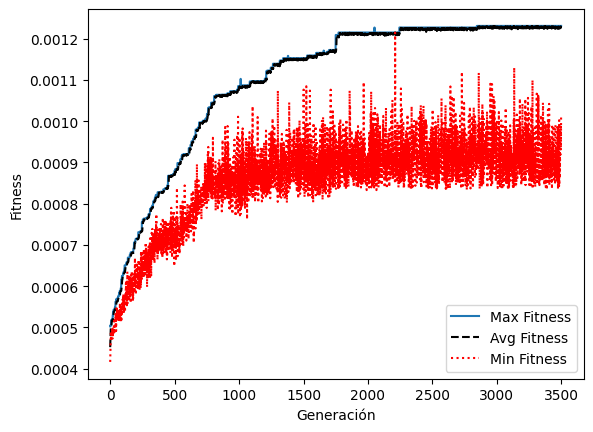

In [8]:
def main():
    
    random.seed(64)
    
    instance_name = 'R101.json'
    ind_size = 100
    pop_size = 400
    cx_pb = 0.85
    mut_pb = 0.02
    n_gen = 3500
    
    pop, logbook =  run_gavrp(instance_name=instance_name, ind_size=ind_size, pop_size=pop_size, cx_pb=cx_pb, mut_pb=mut_pb, n_gen=n_gen)
    
    # Mostrar la evolución del fitness
    plot_evolucion(logbook)


if __name__ == '__main__':
    main()
